# Problem Set 2 - Part 1: Ambiguity and Inference

The lab is an exploration and learning exercise to be done in a group and also in discussion with the teachers and other students.

Before starting, please read the following instructions on [how to work on group assignments](https://github.com/sdobnik/computational-semantics/blob/master/README.md).


### Pre-requisite knowledge

Understanding of `problem-set-1`:
- First order logic
- Lambda calculus
- Feature unification context free grammar

### Instructions

- Follow the instructions step-by-step.
- Run all cells before modifying them to see how the code works.
- The tasks will ask you to modify cells in this notebook.
- Modify the cell to provide your answer and run a test before submiting the file.

In [1]:
# This task requires NLTK and Jupyter Notebook (IPython package).

import nltk
from nltk.grammar import FeatureGrammar
from nltk.sem import cooper_storage as cs

from utils import display_latex, display_translation, display_tree, display, Markdown
from copy import deepcopy

read_expr = nltk.sem.Expression.fromstring

Run the following cell to import functions and syntax specific to this problem set:

In [2]:
from utils2 import sem_parser, evaluate_sentences, syntax, syntax_notv

### 1. Ambiguity in quantifiers [6 marks in total]

Follow the descriptions and instructions in sections **(1.1)**, **(1.2)** and **(1.3)** to learn about the code and the examples. Then answer the questions in section **(1.4)**.

#### 1.1. FCFG with a SEM feature

You should already be familar with FCFG with a SEM feature. 
Use the code below to parse the following sentences to their semantic representations:

1. every dog bites a bone
2. a man gives a bone to every dog
3. Russia gives Moscow to Napoleon

In [3]:
sentences = [
    'all dogs bite a bone',
    'a man gives a bone to every dog',
    'Russia gives Moscow to Napoleon',
]

# if you want to see the parse tree change `verbose` to True:
sents_reps = sem_parser(sentences, syntax, verbose=False)

for i, (sent, semreps) in enumerate(sents_reps.items()):
    for semrep in semreps:
        display_translation(f"{i+1}. {sent}", semrep)

"1. all dogs bite a bone": $\forall\ x.(dog(x)\ \to\ \exists\ z_{1}.(bone(z_{1})\ \land\ bite(x,z_{1})))$

"2. a man gives a bone to every dog": $\exists\ x.(man(x)\ \land\ \forall\ z_{3}.(dog(z_{3})\ \to\ \exists\ z_{2}.(bone(z_{2})\ \land\ give(x,z_{2},z_{3}))))$

"3. Russia gives Moscow to Napoleon": $give(russia,moscow,napoleon)$

#### 1.2. Evaluate sentences in a model

We have a world model with entities and sets to represent their properties and relationships. 
Run the code below to evaluate the sentence representations from the previous section in the world model defined below.

In [5]:
# a world model:
entities = """
russia    => c1
moscow    => c2
napoleon  => m2
"""
unaries = """
dog  => {d1, d2, d3} 
man  => {m1, m2} 
bone => {bn1, bn2} 
"""
binaries = """
bite => {(d1, bn1), (d2, bn2), (d3, bn2)} 
"""
ternaries = """
give => {(c1, c2, m2), (m1, bn1, d1), (m1, bn2, d2), (m1, bn2, d3)} 
"""

# world is a collection of entities and relations:
world = entities + unaries + binaries + ternaries

# parse the sentences:
sents_reps = sem_parser(sentences, syntax, verbose=False)
# evaluate them:
sents_reps_vals = evaluate_sentences(sents_reps, world)

# print all readings
for i, (sent, semreps_vals) in enumerate(sents_reps_vals.items()):
    for semrep, val in semreps_vals.items():
        print(f"{i+1}. {sent}:")
        display_translation(val, semrep)

1. all dogs bite a bone:


"True": $\forall\ x.(dog(x)\ \to\ \exists\ z_{7}.(bone(z_{7})\ \land\ bite(x,z_{7})))$

2. a man gives a bone to every dog:


"True": $\exists\ x.(man(x)\ \land\ \forall\ z_{9}.(dog(z_{9})\ \to\ \exists\ z_{8}.(bone(z_{8})\ \land\ give(x,z_{8},z_{9}))))$

3. Russia gives Moscow to Napoleon:


"True": $give(russia,moscow,napoleon)$

#### 1.3. Exploiting syntactic ambiguity to represent semantic ambiguity

Ditransitive verbs (`DTV`) have two objects. Use the code below to inspect the lexical representation of `give(s)` in the grammar. When constructing a `VP`, we take the semantic representation of a di-trasitive verb `DTV`as a function and apply it on both direct and indirect objects: `vp = ?dtv(?obj,?pp)`. The lambda bound variables `Y` and `X` are substituted with `?obj` and `?pp`.

In [7]:
print(syntax.productions()[-1])
print(syntax.productions()[-5])

DTV[NUM='pl', SEM=<\Y X x.X(\z.Y(\y.give(x,y,z)))>, TNS='pres'] -> 'give'
VP[NUM=?n, SEM=<?v(?obj,?pp)>] -> DTV[NUM=?n, SEM=?v] NP[SEM=?obj] PP[SEM=?pp, +TO]


In the lecture we discussed that without a mechanism such as Cooper storage we would only get one scoping of quanitifers.

One trick to ensure a different scoping for `give(s)` is  to create a parallel syntactic rule that contains a different internal order of composition of arguments in the `SEM`feature as follows: 

For example, we can change the compositional function from:
$$\lambda Y\ X\ x.X(\lambda z.Y(\lambda y.give(x,y,z)))$$
to:
$$\lambda Y\ X\ x.Y(\lambda y.X(\lambda z.give(x,y,z)))$$

As we now have two rules for `DTV` this will introduce syntactic ambiguity when a parses encouters words such `give(s)`.
The following code adds two alternative rules to those in the previous cell. Run the code to see the parse results for sentences and their evaluation in the model.

In [8]:
fcfg_string_give = r"""
DTV[NUM=sg,SEM=<\Y X x.Y(\y.X(\z.give(x,y,z)))>,TNS=pres] -> 'gives'
DTV[NUM=pl,SEM=<\Y X x.Y(\y.X(\z.give(x,y,z)))>,TNS=pres] -> 'give'
"""

# this is going to add new rules to the syntax:
new_syntax = FeatureGrammar(
    syntax.start(),
    syntax.productions() + FeatureGrammar.fromstring(fcfg_string_give).productions()
)

# parse the sentences with new syntax:
sents_reps = sem_parser(sentences, new_syntax, verbose=False)
# evaluate them:
sents_reps_vals = evaluate_sentences(sents_reps, world)

for i, (sent, semreps_vals) in enumerate(sents_reps_vals.items()):
    for semrep, val in semreps_vals.items():
        print(f"{i+1}. {sent}:")
        display_translation(val, semrep)

1. all dogs bite a bone:


"True": $\forall\ x.(dog(x)\ \to\ \exists\ z_{10}.(bone(z_{10})\ \land\ bite(x,z_{10})))$

2. a man gives a bone to every dog:


"True": $\exists\ x.(man(x)\ \land\ \forall\ z_{14}.(dog(z_{14})\ \to\ \exists\ z_{13}.(bone(z_{13})\ \land\ give(x,z_{13},z_{14}))))$

2. a man gives a bone to every dog:


"False": $\exists\ x.(man(x)\ \land\ \exists\ z_{11}.(bone(z_{11})\ \land\ \forall\ z_{12}.(dog(z_{12})\ \to\ give(x,z_{11},z_{12}))))$

3. Russia gives Moscow to Napoleon:


"True": $give(russia,moscow,napoleon)$

#### 1.4. Questions

**1a.** Because the word `give`can now be expanded following two rules we get two extra parse trees for the second and and the third sentence. Answer the following questions: **[2 marks]**
   - Why sentence (2) with `give` has two different readings but sentence (3) has only one reading?
   - What is the difference between the two representations of sentence (2)?

**The Answer**: As we have two rules for the `DTV`, each rule provide a representation for a sentence. Regarding `sentence (2)`, the different order for the verb arguments leads to two different represtations. The *original rule* place the `NP` representation in a place that leads to make the scope of the existential quantifier is related to the most inner part the `VP = VT NP` representation. On the other hand, the *second rule* will lead to a representation that have the existential quantifier scope is related to the most outer part. The existing of two rules introduce simulate the quantifier ambiguity problem.

For `sentence (3)`, the two rules provide the same representation; the rules applied are related to `Proper Noun` where for each rule, the `city name` are placed in its right place.

The **parsing trees** below better illustrate the answer.

The *first reading* of `sentence (2)` can be interpreted as "one man who gives a bone to all dogs" while the *second reading* can mean that "one man gives the same bone to all dogs"

----

$\exists\ x.(man(x)\ \land\ \forall\ z_{18}.(dog(z_{18})\ \to\ \exists\ z_{17}.(bone(z_{17})\ \land\ give(x,z_{17},z_{18}))))$

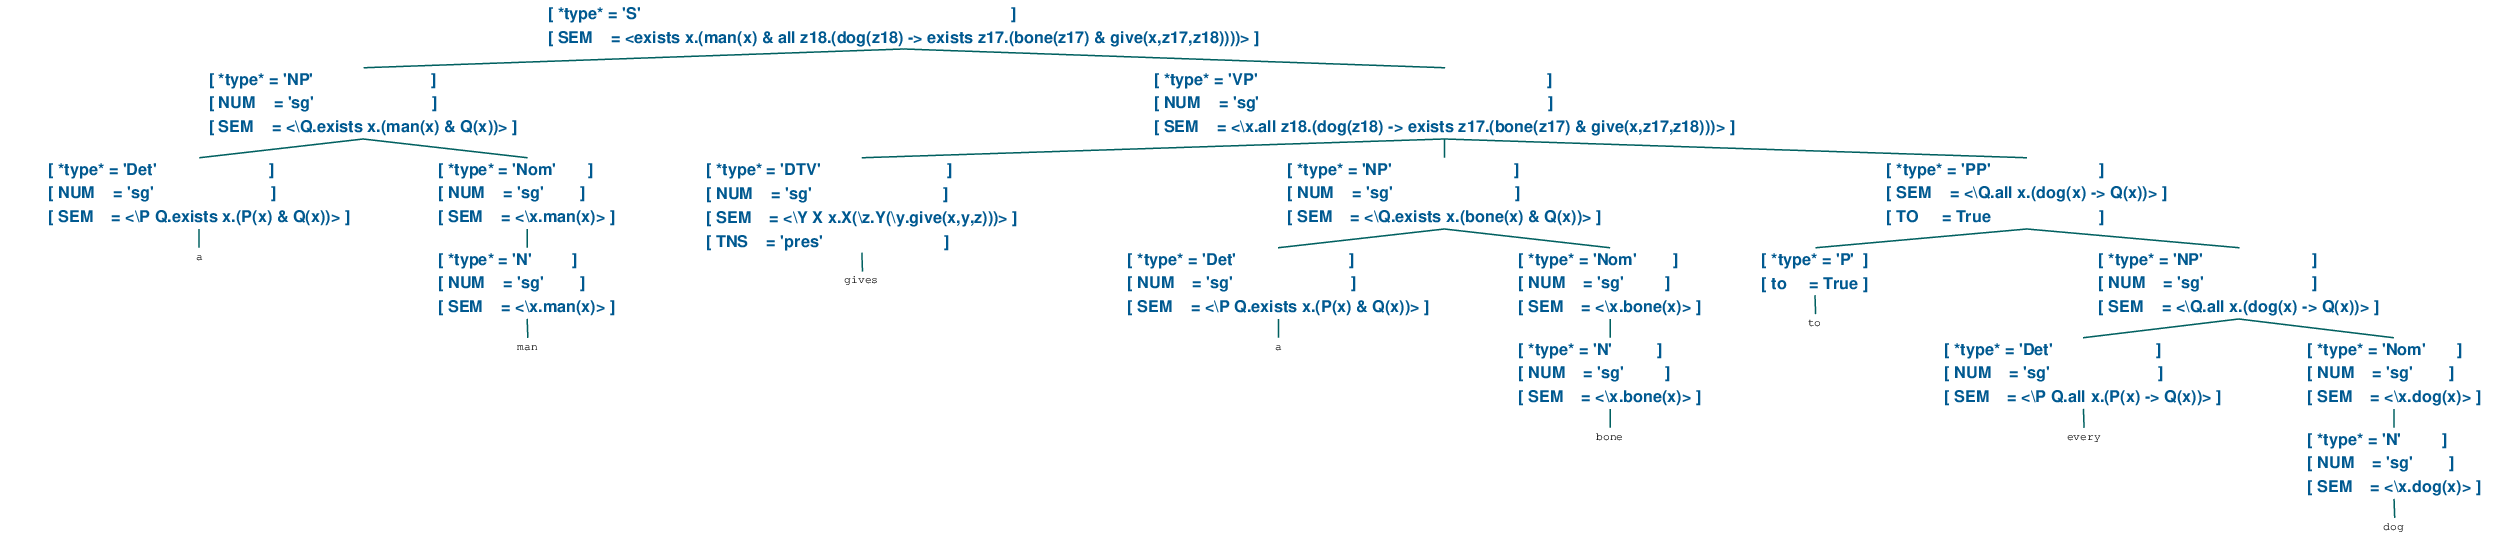

----

$\exists\ x.(man(x)\ \land\ \exists\ z_{15}.(bone(z_{15})\ \land\ \forall\ z_{16}.(dog(z_{16})\ \to\ give(x,z_{15},z_{16}))))$

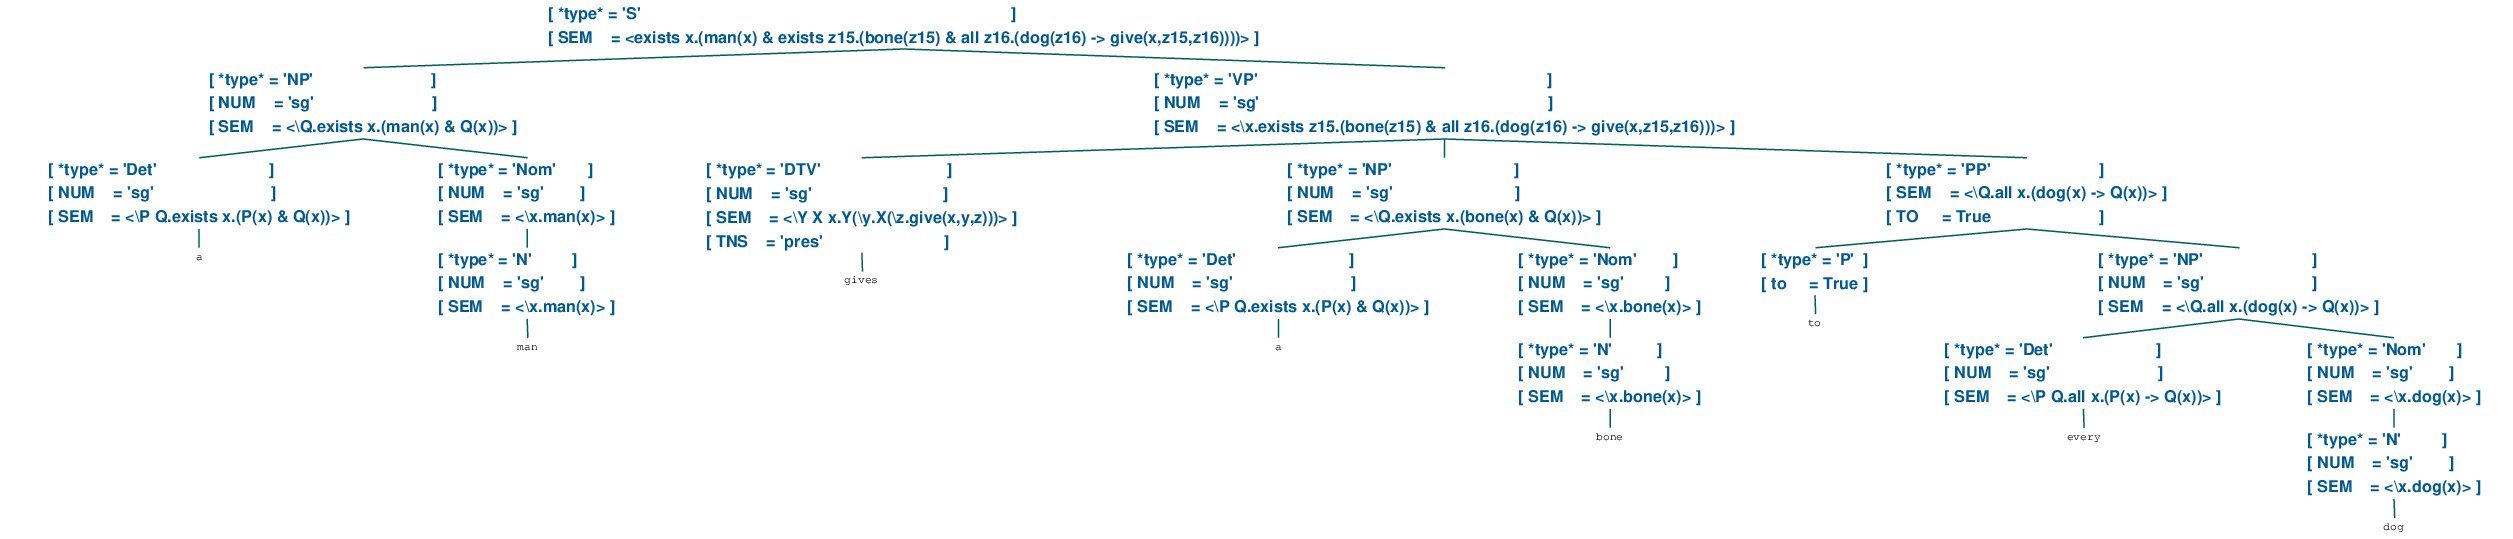

----

$give(russia,moscow,napoleon)$

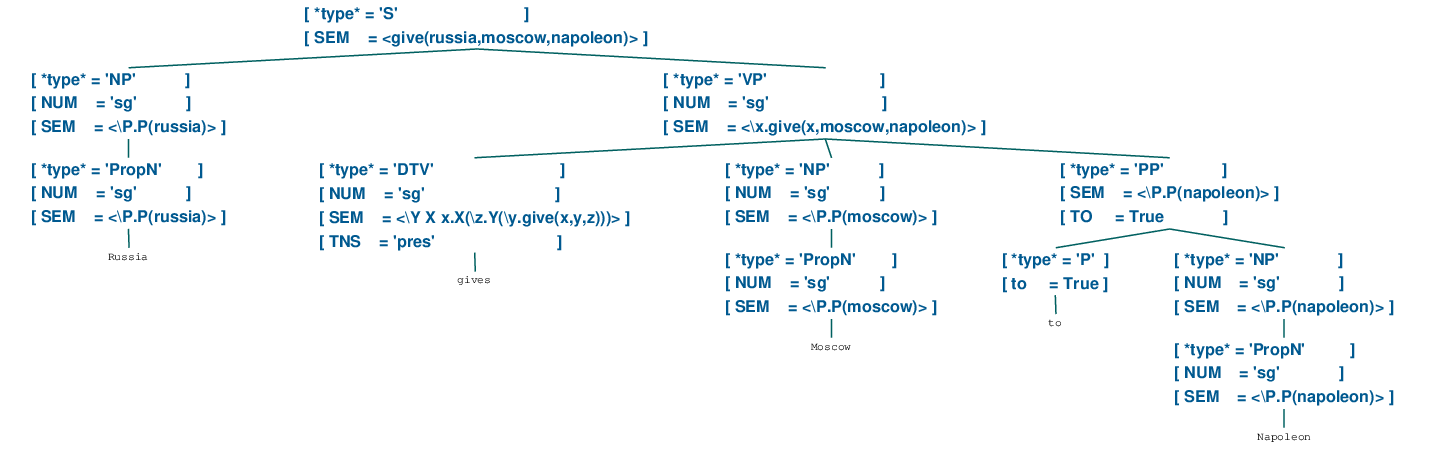

----

$give(russia,moscow,napoleon)$

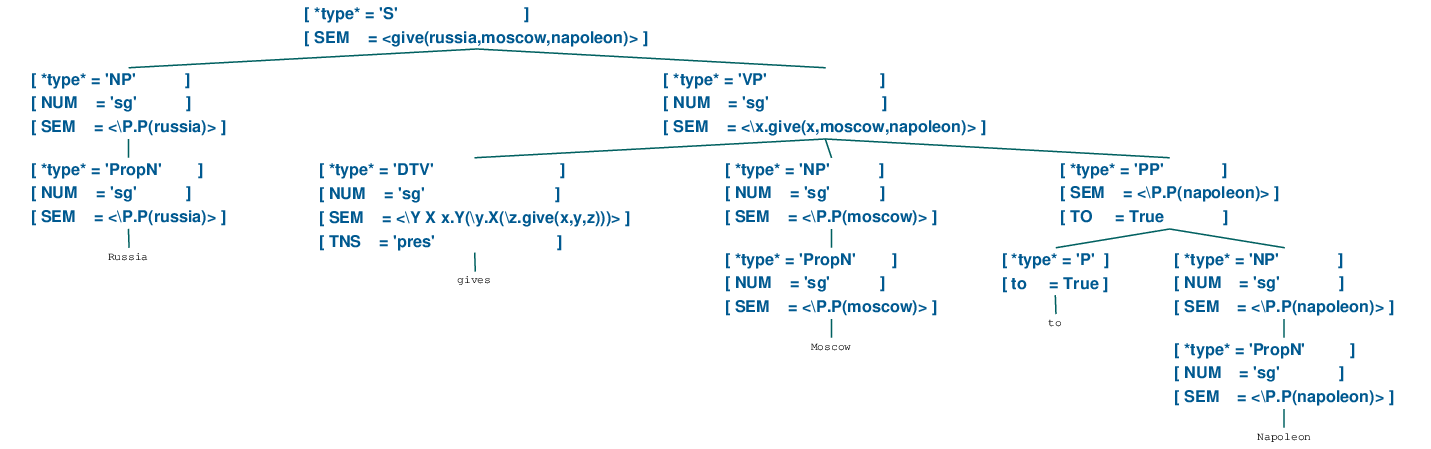

In [9]:
from nltk.draw.tree import TreeView
mysentences = sentences[1:]
for i, results in enumerate(nltk.interpret_sents(mysentences, new_syntax)):
    for j, (synrep, semrep) in enumerate(results):
        display(Markdown('----'))
        display_latex(semrep) # prints the SEM feature of a tree
        display_tree(synrep) # show the parse tree

**1b.** When you evalute sentence (2) in the model above, one reading is True and the other is False. Change the part of the model marked with `???` so that all readings all sentences will be True. **[1 marks]** 

Explain why the readings are true. **[+1 mark]**

In [11]:
ternaries = """
give => {(c1, c2, m2), (m1, bn2, d1), (m1, bn2, d2), (m1, bn2, d3)}
"""

# new world
world = entities + unaries + binaries + ternaries

# evaluate them:
sents_reps_vals = evaluate_sentences(sents_reps, world)

for sent, semreps_vals in sents_reps_vals.items():
    for semrep, val in semreps_vals.items():
        print(f"{sent}:")
        display_translation(val, semrep)

all dogs bite a bone:


"True": $\forall\ x.(dog(x)\ \to\ \exists\ z_{10}.(bone(z_{10})\ \land\ bite(x,z_{10})))$

a man gives a bone to every dog:


"True": $\exists\ x.(man(x)\ \land\ \forall\ z_{14}.(dog(z_{14})\ \to\ \exists\ z_{13}.(bone(z_{13})\ \land\ give(x,z_{13},z_{14}))))$

a man gives a bone to every dog:


"True": $\exists\ x.(man(x)\ \land\ \exists\ z_{11}.(bone(z_{11})\ \land\ \forall\ z_{12}.(dog(z_{12})\ \to\ give(x,z_{11},z_{12}))))$

Russia gives Moscow to Napoleon:


"True": $give(russia,moscow,napoleon)$

**The answer**:  
Since the second interpretation states that at least one man gives the same bone to all dogs, we changed the model so that it's always `bn2` that is given to dogs. The first reading is still true, since it only demands that a bone be given to every dog, no matter which one.

**1c.** Consider a world with a `bite` relation as shown below.
Write *another* representation of the sentence "all dogs bite a bone" 
that is different from the one you get above and that is *True* in this model. 
Write your answer in `???`. **[1 mark]** 

In [12]:
binaries = """
bite => {(d1, bn1), (d2, bn1), (d3, bn1)} 
"""

# new world
world = entities + unaries + binaries + ternaries

sents_reps_copy = deepcopy(sents_reps)
sents_reps_copy['all dogs bite a bone'].append(
    read_expr(r"exists y. (bone(y) & all x. (dog(x) -> bite(x,y)))")
)

# evaluate them:
sents_reps_vals_copy = evaluate_sentences(sents_reps_copy, world)

for i, (sent, semreps_vals) in enumerate(sents_reps_vals_copy.items()):
    if sent == 'all dogs bite a bone':
        for semrep, val in semreps_vals.items():
            print(f"{i+1}. {sent}:")
            display_translation(val, semrep)

1. all dogs bite a bone:


"True": $\forall\ x.(dog(x)\ \to\ \exists\ z_{10}.(bone(z_{10})\ \land\ bite(x,z_{10})))$

1. all dogs bite a bone:


"True": $\exists\ y.(bone(y)\ \land\ \forall\ x.(dog(x)\ \to\ bite(x,y)))$

**1d.** Consider a new set of tuples representing the `give` predicate below.
Write *another* representation for "a man gives a bone to every dog"
that is *True* in the updated model.
Write your answer in `???`. **[1 mark]** 

In [14]:
ternaries = """
give => {(c1, c2, m2), (m2, bn1, d1), (m1, bn1, d2), (m1, bn1, d3)}
"""

# new world
world = entities + unaries + binaries + ternaries

sents_reps_copy = deepcopy(sents_reps)
sents_reps_copy['a man gives a bone to every dog'].append(
    read_expr(r"(all z.(dog(z) -> (exists x.(man(x) & exists y. (bone(y) & give(x,y,z))))))")
)

# evaluate them:
sents_reps_vals_copy = evaluate_sentences(sents_reps_copy, world)

for i, (sent, semreps_vals) in enumerate(sents_reps_vals_copy.items()):
    if sent == 'a man gives a bone to every dog':
        for semrep, val in semreps_vals.items():
            print(f"{i+1}. {sent}:")
            display_translation(val, semrep)

2. a man gives a bone to every dog:


"False": $\exists\ x.(man(x)\ \land\ \forall\ z_{14}.(dog(z_{14})\ \to\ \exists\ z_{13}.(bone(z_{13})\ \land\ give(x,z_{13},z_{14}))))$

2. a man gives a bone to every dog:


"False": $\exists\ x.(man(x)\ \land\ \exists\ z_{11}.(bone(z_{11})\ \land\ \forall\ z_{12}.(dog(z_{12})\ \to\ give(x,z_{11},z_{12}))))$

2. a man gives a bone to every dog:


"True": $\forall\ z.(dog(z)\ \to\ \exists\ x.(man(x)\ \land\ \exists\ y.(bone(y)\ \land\ give(x,y,z))))$

### 2. Cooper storage [8 marks in total]

#### 2.1. Learn about CooperSotrage
Study the following grammar with a `SEM` that is split between `CORE` and `STORE`. However, in this example, we never add anything to the `STORE`.

In [15]:
fcfg_storage_base = r"""
% start S

S[SEM=[CORE=<?subj(?vp)>, STORE=(?b1+?b2)]] -> NP[NUM=?n,SEM=[CORE=?subj, STORE=?b1]] VP[NUM=?n,SEM=[CORE=?vp, STORE=?b2]]

Nom[NUM=?n,SEM=?s] -> N[NUM=?n,SEM=?s]

VP[NUM=?n,SEM=?s] -> IV[NUM=?n,SEM=?s]
VP[NUM=?n,SEM=[CORE=<?v(?obj)>, STORE=(?b1+?b2)]] -> TV[NUM=?n,SEM=[CORE=?v, STORE=?b1]] NP[SEM=[CORE=?obj, STORE=?b2]]
VP[NUM=?n,SEM=[CORE=<?v(?pp)(?obj)>, STORE=(?b1+?b2+?b3)]] -> DTV[NUM=?n,SEM=[CORE=?v, STORE=?b1]] NP[SEM=[CORE=?obj, STORE=?b2]] PP[+TO,SEM=[CORE=?pp, STORE=?b3]]

PP[+TO, SEM=[CORE=?np, STORE=?b1]] -> P[+TO] NP[SEM=[CORE=?np, STORE=?b1]]
"""

fcfg_storage_lexicon = r"""
PropN[NUM=sg,SEM=[CORE=<\P.P(angus)>, STORE=(/)]] -> 'Angus'
PropN[NUM=sg,SEM=[CORE=<\P.P(cyril)>, STORE=(/)]] -> 'Cyril'
PropN[NUM=sg,SEM=[CORE=<\P.P(irene)>, STORE=(/)]] -> 'Irene'

Det[NUM=sg,SEM=[CORE=<\P Q.all x.(P(x) -> Q(x))>, STORE=(/)]] -> 'every'
Det[NUM=sg,SEM=[CORE=<\P Q.exists x.(P(x) & Q(x))>, STORE=(/)]] -> 'a'

N[NUM=sg,SEM=[CORE=<\x.library(x)>, STORE=(/)]] -> 'library'
N[NUM=sg,SEM=[CORE=<\x.girl(x)>, STORE=(/)]] -> 'girl'
N[NUM=sg,SEM=[CORE=<\x.boy(x)>, STORE=(/)]] -> 'boy'
N[NUM=sg,SEM=[CORE=<\x.book(x)>, STORE=(/)]] -> 'book'

IV[NUM=sg,SEM=[CORE=<\x.smile(x)>, STORE=(/)],TNS=pres] -> 'smiles' 

TV[NUM=sg,SEM=[CORE=<\X x.X(\y.read(x,y))>, STORE=(/)],TNS=pres] -> 'reads'

DTV[NUM=sg,SEM=[CORE=<\Y X x.X(\z.Y(\y.give(x,y,z)))>, STORE=(/)],TNS=pres] -> 'gives'

P[+to] -> 'to'
""" 

fcfg_storage_np = r"""
NP[NUM=?n,SEM=[CORE=?np, STORE=?b1]] -> PropN[NUM=?n,SEM=[CORE=?np, STORE=?b1]]
NP[NUM=?n,SEM=[CORE=<?det(?nom)>, STORE=(?b1+?b2)]] -> Det[NUM=?n,SEM=[CORE=?det, STORE=?b1]] Nom[NUM=?n,SEM=[CORE=?nom, STORE=?b2]]
"""

sentences = [
    'Angus reads a book',
    'every girl reads a book',
    'every library gives a book to a girl',
]

fcfg_storage = fcfg_storage_base + fcfg_storage_np + fcfg_storage_lexicon
cs_syntax = FeatureGrammar.fromstring(fcfg_storage)
sents_reps = sem_parser(sentences, cs_syntax, verbose=False, is_cs=True)

for i, (sent, semreps) in enumerate(sents_reps.items()):
    counter = 0
    print(f"{i+1}. {sent}")
    for semrep in semreps:
        counter += 1
        display_translation(counter, semrep)

1. Angus reads a book


"1": $\exists\ z_{19}.(book(z_{19})\ \land\ read(angus,z_{19}))$

2. every girl reads a book


"1": $\forall\ x.(girl(x)\ \to\ \exists\ z_{20}.(book(z_{20})\ \land\ read(x,z_{20})))$

3. every library gives a book to a girl


"1": $\forall\ x.(library(x)\ \to\ \exists\ z_{22}.(book(z_{22})\ \land\ \exists\ z_{21}.(girl(z_{21})\ \land\ give(x,z_{21},z_{22}))))$

With the following change to the `NP` rule we push representations to the `STORE` and replace them with a simple varible in the `CORE` (which is then type raised to <<e,t>,t> so that it it can combine with a transitive verb entry).

In [16]:
fcfg_storage_np = r"""
NP[NUM=?n,SEM=[CORE=<\P.P(@x)>, STORE=(<bo(?np, @x)>+?b1)]] -> PropN[NUM=?n,SEM=[CORE=?np, STORE=?b1]]
NP[NUM=?n,SEM=[CORE=<\P.P(@x)>, STORE=(<bo(?det(?nom), @x)>+?b1+?b2)]] -> Det[NUM=?n,SEM=[CORE=?det, STORE=?b1]] Nom[NUM=?n,SEM=[CORE=?nom, STORE=?b2]]
"""

sentences = [
    'Angus reads a book',
    'every girl reads a book',
    'every library gives a book to a girl',
]

fcfg_storage = fcfg_storage_base + fcfg_storage_np + fcfg_storage_lexicon
cs_syntax = FeatureGrammar.fromstring(fcfg_storage)
sents_reps = sem_parser(sentences, cs_syntax, verbose=False, is_cs=True)

for i, (sent, semreps) in enumerate(sents_reps.items()):
    counter = 0
    print(f"{i+1}. {sent}")
    for semrep in semreps:
        counter += 1
        display_translation(counter, semrep)

1. Angus reads a book


"1": $\exists\ x.(book(x)\ \land\ read(angus,x))$

"2": $\exists\ x.(book(x)\ \land\ read(angus,x))$

2. every girl reads a book


"1": $\exists\ x.(book(x)\ \land\ \forall\ z_{23}.(girl(z_{23})\ \to\ read(z_{23},x)))$

"2": $\forall\ x.(girl(x)\ \to\ \exists\ z_{24}.(book(z_{24})\ \land\ read(x,z_{24})))$

3. every library gives a book to a girl


"1": $\exists\ x.(girl(x)\ \land\ \exists\ z_{26}.(book(z_{26})\ \land\ \forall\ z_{25}.(library(z_{25})\ \to\ give(z_{25},x,z_{26}))))$

"2": $\exists\ x.(book(x)\ \land\ \exists\ z_{28}.(girl(z_{28})\ \land\ \forall\ z_{27}.(library(z_{27})\ \to\ give(z_{27},z_{28},x))))$

"3": $\exists\ x.(girl(x)\ \land\ \forall\ z_{30}.(library(z_{30})\ \to\ \exists\ z_{29}.(book(z_{29})\ \land\ give(z_{30},x,z_{29}))))$

"4": $\forall\ x.(library(x)\ \to\ \exists\ z_{32}.(girl(z_{32})\ \land\ \exists\ z_{31}.(book(z_{31})\ \land\ give(x,z_{32},z_{31}))))$

"5": $\exists\ x.(book(x)\ \land\ \forall\ z_{34}.(library(z_{34})\ \to\ \exists\ z_{33}.(girl(z_{33})\ \land\ give(z_{34},z_{33},x))))$

"6": $\forall\ x.(library(x)\ \to\ \exists\ z_{36}.(book(z_{36})\ \land\ \exists\ z_{35}.(girl(z_{35})\ \land\ give(x,z_{35},z_{36}))))$

#### 2.2. Questions

**2a.** There are two identical readings of the first sentence. Why is this so? Suggest a change that would ensure you do not get doublicate readings for the first sentence but you get  alternative readings for the other sentence. **[2 marks]**

**Write explanation here** The first sentence also includes a quantifier, so with the cooper storage it gets two different readings. But since it's only one quantifier and a proper noun, there is no difference between the readings. A solution to this would be to keep the store empty for proper nouns, but keep it for other noun phrases. ...

In [17]:
sentences = [
    'Angus reads a book',
    'every girl reads a book'
]

fcfg_storage_np = r"""
## Change the rule below:
NP[NUM=?n,SEM=[CORE=?np, STORE=?b1]] -> PropN[NUM=?n,SEM=[CORE=?np, STORE=?b1]]
NP[NUM=?n,SEM=[CORE=<\P.P(@x)>, STORE=(<bo(?det(?nom), @x)>+?b1+?b2)]] -> Det[NUM=?n,SEM=[CORE=?det, STORE=?b1]] Nom[NUM=?n,SEM=[CORE=?nom, STORE=?b2]]
"""


fcfg_storage = fcfg_storage_base + fcfg_storage_np + fcfg_storage_lexicon 
cs_syntax = FeatureGrammar.fromstring(fcfg_storage)
sents_reps = sem_parser(sentences, cs_syntax, verbose=False, is_cs=True)

for i, (sent, semreps) in enumerate(sents_reps.items()):
    counter = 0
    print(f"{i+1}. {sent}")
    for semrep in semreps:
        counter += 1
        display_translation(counter, semrep)

1. Angus reads a book


"1": $\exists\ x.(book(x)\ \land\ read(angus,x))$

2. every girl reads a book


"1": $\exists\ x.(book(x)\ \land\ \forall\ z_{37}.(girl(z_{37})\ \to\ read(z_{37},x)))$

"2": $\forall\ x.(girl(x)\ \to\ \exists\ z_{38}.(book(z_{38})\ \land\ read(x,z_{38})))$

**2b.** Extend the grammar below to cover the following sentences: **[6 marks]**

In [18]:
sentences = [
    'every library gives a book to every girl and every boy',
    'no library gives every book to a boy',
    'a boy and a girl read all books',
    'Angus and Irene read all books',
]

# your answers
fcfg_storage_answers_1 = r"""
### Replace X with their proper representations
Det[NUM=sg,SEM=[CORE=<\P Q. -exists x.(P(x) & Q(x))>, STORE=(/)]] -> 'no'
Det[NUM=pl,SEM=[CORE=<\P Q.all x.(P(x) -> Q(x))>, STORE=(/)]] -> 'all'
N[NUM=pl,SEM=[CORE=<\x.book(x)>, STORE=(/)]] -> 'books'
TV[NUM=pl,SEM=[CORE=<\X x.X(\y.read(x,y))>, STORE=(/)],TNS=pres] -> 'read'
"""

fcfg_storage_answers_2 = r"""
### Correct the conjunction rule here. Replace xxx and ??? with the correct answer:
NP[NUM=pl, SEM=[CORE=<\P. (?n1(P) & ?n2(P))>, STORE=(?b1+?b2)]] -> NP[NUM=?num1, SEM=[CORE=?n1, STORE=?b1]] CONJ NP[NUM=?num2, SEM=[CORE=?n2, STORE=?b2]]
CONJ -> 'and'
"""


fcfg_storage = fcfg_storage_base + fcfg_storage_np + fcfg_storage_lexicon + fcfg_storage_answers_1 + fcfg_storage_answers_2
cs_syntax = FeatureGrammar.fromstring(fcfg_storage)
sents_reps = sem_parser(sentences, cs_syntax, verbose=False, is_cs=True)

for i, (sent, semreps) in enumerate(sents_reps.items()):
    counter = 0
    print(f"{i+1}. {sent}")
    for semrep in semreps:
        counter += 1
        display_translation(counter, semrep)

1. every library gives a book to every girl and every boy


"1": $\forall\ x.(boy(x)\ \to\ \forall\ z_{41}.(girl(z_{41})\ \to\ \exists\ z_{40}.(book(z_{40})\ \land\ \forall\ z_{39}.(library(z_{39})\ \to\ (give(z_{39},z_{41},z_{40})\ \land\ give(z_{39},x,z_{40}))))))$

"2": $\forall\ x.(girl(x)\ \to\ \forall\ z_{44}.(boy(z_{44})\ \to\ \exists\ z_{43}.(book(z_{43})\ \land\ \forall\ z_{42}.(library(z_{42})\ \to\ (give(z_{42},x,z_{43})\ \land\ give(z_{42},z_{44},z_{43}))))))$

"3": $\forall\ x.(boy(x)\ \to\ \exists\ z_{47}.(book(z_{47})\ \land\ \forall\ z_{46}.(girl(z_{46})\ \to\ \forall\ z_{45}.(library(z_{45})\ \to\ (give(z_{45},z_{46},z_{47})\ \land\ give(z_{45},x,z_{47}))))))$

"4": $\exists\ x.(book(x)\ \land\ \forall\ z_{50}.(boy(z_{50})\ \to\ \forall\ z_{49}.(girl(z_{49})\ \to\ \forall\ z_{48}.(library(z_{48})\ \to\ (give(z_{48},z_{49},x)\ \land\ give(z_{48},z_{50},x))))))$

"5": $\forall\ x.(girl(x)\ \to\ \exists\ z_{53}.(book(z_{53})\ \land\ \forall\ z_{52}.(boy(z_{52})\ \to\ \forall\ z_{51}.(library(z_{51})\ \to\ (give(z_{51},x,z_{53})\ \land\ give(z_{51},z_{52},z_{53}))))))$

"6": $\exists\ x.(book(x)\ \land\ \forall\ z_{56}.(girl(z_{56})\ \to\ \forall\ z_{55}.(boy(z_{55})\ \to\ \forall\ z_{54}.(library(z_{54})\ \to\ (give(z_{54},z_{56},x)\ \land\ give(z_{54},z_{55},x))))))$

"7": $\forall\ x.(boy(x)\ \to\ \forall\ z_{59}.(girl(z_{59})\ \to\ \forall\ z_{58}.(library(z_{58})\ \to\ \exists\ z_{57}.(book(z_{57})\ \land\ give(z_{58},z_{59},z_{57})\ \land\ give(z_{58},x,z_{57})))))$

"8": $\forall\ x.(girl(x)\ \to\ \forall\ z_{62}.(boy(z_{62})\ \to\ \forall\ z_{61}.(library(z_{61})\ \to\ \exists\ z_{60}.(book(z_{60})\ \land\ give(z_{61},x,z_{60})\ \land\ give(z_{61},z_{62},z_{60})))))$

"9": $\forall\ x.(boy(x)\ \to\ \forall\ z_{65}.(library(z_{65})\ \to\ \forall\ z_{64}.(girl(z_{64})\ \to\ \exists\ z_{63}.(book(z_{63})\ \land\ give(z_{65},z_{64},z_{63})\ \land\ give(z_{65},x,z_{63})))))$

"10": $\forall\ x.(library(x)\ \to\ \forall\ z_{68}.(boy(z_{68})\ \to\ \forall\ z_{67}.(girl(z_{67})\ \to\ \exists\ z_{66}.(book(z_{66})\ \land\ give(x,z_{67},z_{66})\ \land\ give(x,z_{68},z_{66})))))$

"11": $\forall\ x.(girl(x)\ \to\ \forall\ z_{71}.(library(z_{71})\ \to\ \forall\ z_{70}.(boy(z_{70})\ \to\ \exists\ z_{69}.(book(z_{69})\ \land\ give(z_{71},x,z_{69})\ \land\ give(z_{71},z_{70},z_{69})))))$

"12": $\forall\ x.(library(x)\ \to\ \forall\ z_{74}.(girl(z_{74})\ \to\ \forall\ z_{73}.(boy(z_{73})\ \to\ \exists\ z_{72}.(book(z_{72})\ \land\ give(x,z_{74},z_{72})\ \land\ give(x,z_{73},z_{72})))))$

"13": $\forall\ x.(boy(x)\ \to\ \exists\ z_{77}.(book(z_{77})\ \land\ \forall\ z_{76}.(library(z_{76})\ \to\ \forall\ z_{75}.(girl(z_{75})\ \to\ (give(z_{76},z_{75},z_{77})\ \land\ give(z_{76},x,z_{77}))))))$

"14": $\exists\ x.(book(x)\ \land\ \forall\ z_{80}.(boy(z_{80})\ \to\ \forall\ z_{79}.(library(z_{79})\ \to\ \forall\ z_{78}.(girl(z_{78})\ \to\ (give(z_{79},z_{78},x)\ \land\ give(z_{79},z_{80},x))))))$

"15": $\forall\ x.(boy(x)\ \to\ \forall\ z_{83}.(library(z_{83})\ \to\ \exists\ z_{82}.(book(z_{82})\ \land\ \forall\ z_{81}.(girl(z_{81})\ \to\ (give(z_{83},z_{81},z_{82})\ \land\ give(z_{83},x,z_{82}))))))$

"16": $\forall\ x.(library(x)\ \to\ \forall\ z_{86}.(boy(z_{86})\ \to\ \exists\ z_{85}.(book(z_{85})\ \land\ \forall\ z_{84}.(girl(z_{84})\ \to\ (give(x,z_{84},z_{85})\ \land\ give(x,z_{86},z_{85}))))))$

"17": $\exists\ x.(book(x)\ \land\ \forall\ z_{89}.(library(z_{89})\ \to\ \forall\ z_{88}.(boy(z_{88})\ \to\ \forall\ z_{87}.(girl(z_{87})\ \to\ (give(z_{89},z_{87},x)\ \land\ give(z_{89},z_{88},x))))))$

"18": $\forall\ x.(library(x)\ \to\ \exists\ z_{92}.(book(z_{92})\ \land\ \forall\ z_{91}.(boy(z_{91})\ \to\ \forall\ z_{90}.(girl(z_{90})\ \to\ (give(x,z_{90},z_{92})\ \land\ give(x,z_{91},z_{92}))))))$

"19": $\forall\ x.(girl(x)\ \to\ \exists\ z_{95}.(book(z_{95})\ \land\ \forall\ z_{94}.(library(z_{94})\ \to\ \forall\ z_{93}.(boy(z_{93})\ \to\ (give(z_{94},x,z_{95})\ \land\ give(z_{94},z_{93},z_{95}))))))$

"20": $\exists\ x.(book(x)\ \land\ \forall\ z_{98}.(girl(z_{98})\ \to\ \forall\ z_{97}.(library(z_{97})\ \to\ \forall\ z_{96}.(boy(z_{96})\ \to\ (give(z_{97},z_{98},x)\ \land\ give(z_{97},z_{96},x))))))$

"21": $\forall\ x.(girl(x)\ \to\ \forall\ z_{101}.(library(z_{101})\ \to\ \exists\ z_{100}.(book(z_{100})\ \land\ \forall\ z_{99}.(boy(z_{99})\ \to\ (give(z_{101},x,z_{100})\ \land\ give(z_{101},z_{99},z_{100}))))))$

"22": $\forall\ x.(library(x)\ \to\ \forall\ z_{104}.(girl(z_{104})\ \to\ \exists\ z_{103}.(book(z_{103})\ \land\ \forall\ z_{102}.(boy(z_{102})\ \to\ (give(x,z_{104},z_{103})\ \land\ give(x,z_{102},z_{103}))))))$

"23": $\exists\ x.(book(x)\ \land\ \forall\ z_{107}.(library(z_{107})\ \to\ \forall\ z_{106}.(girl(z_{106})\ \to\ \forall\ z_{105}.(boy(z_{105})\ \to\ (give(z_{107},z_{106},x)\ \land\ give(z_{107},z_{105},x))))))$

"24": $\forall\ x.(library(x)\ \to\ \exists\ z_{110}.(book(z_{110})\ \land\ \forall\ z_{109}.(girl(z_{109})\ \to\ \forall\ z_{108}.(boy(z_{108})\ \to\ (give(x,z_{109},z_{110})\ \land\ give(x,z_{108},z_{110}))))))$

2. no library gives every book to a boy


"1": $\exists\ x.(boy(x)\ \land\ \forall\ z_{112}.(book(z_{112})\ \to\ -\exists\ z_{111}.(library(z_{111})\ \land\ give(z_{111},x,z_{112}))))$

"2": $\forall\ x.(book(x)\ \to\ \exists\ z_{114}.(boy(z_{114})\ \land\ -\exists\ z_{113}.(library(z_{113})\ \land\ give(z_{113},z_{114},x))))$

"3": $\exists\ x.(boy(x)\ \land\ -\exists\ z_{116}.(library(z_{116})\ \land\ \forall\ z_{115}.(book(z_{115})\ \to\ give(z_{116},x,z_{115}))))$

"4": $-\exists\ x.(library(x)\ \land\ \exists\ z_{118}.(boy(z_{118})\ \land\ \forall\ z_{117}.(book(z_{117})\ \to\ give(x,z_{118},z_{117}))))$

"5": $\forall\ x.(book(x)\ \to\ -\exists\ z_{120}.(library(z_{120})\ \land\ \exists\ z_{119}.(boy(z_{119})\ \land\ give(z_{120},z_{119},x))))$

"6": $-\exists\ x.(library(x)\ \land\ \forall\ z_{122}.(book(z_{122})\ \to\ \exists\ z_{121}.(boy(z_{121})\ \land\ give(x,z_{121},z_{122}))))$

3. a boy and a girl read all books


"1": $\forall\ x.(book(x)\ \to\ \exists\ z_{124}.(girl(z_{124})\ \land\ \exists\ z_{123}.(boy(z_{123})\ \land\ read(z_{123},x)\ \land\ read(z_{124},x))))$

"2": $\exists\ x.(girl(x)\ \land\ \forall\ z_{126}.(book(z_{126})\ \to\ \exists\ z_{125}.(boy(z_{125})\ \land\ read(z_{125},z_{126})\ \land\ read(x,z_{126}))))$

"3": $\forall\ x.(book(x)\ \to\ \exists\ z_{128}.(boy(z_{128})\ \land\ \exists\ z_{127}.(girl(z_{127})\ \land\ read(z_{128},x)\ \land\ read(z_{127},x))))$

"4": $\exists\ x.(boy(x)\ \land\ \forall\ z_{130}.(book(z_{130})\ \to\ \exists\ z_{129}.(girl(z_{129})\ \land\ read(x,z_{130})\ \land\ read(z_{129},z_{130}))))$

"5": $\exists\ x.(girl(x)\ \land\ \exists\ z_{132}.(boy(z_{132})\ \land\ \forall\ z_{131}.(book(z_{131})\ \to\ (read(z_{132},z_{131})\ \land\ read(x,z_{131})))))$

"6": $\exists\ x.(boy(x)\ \land\ \exists\ z_{134}.(girl(z_{134})\ \land\ \forall\ z_{133}.(book(z_{133})\ \to\ (read(x,z_{133})\ \land\ read(z_{134},z_{133})))))$

4. Angus and Irene read all books


"1": $\forall\ x.(book(x)\ \to\ (read(angus,x)\ \land\ read(irene,x)))$

**2c.** Add the quantified expressions to the `STORE` only in the conjunction rule. Compare the number of readings you get now for the sentence below. Are there any invalid readings? If so, why? **[3 marks]**

**Answer here:** 

Yes there are some invalide readings.
The output has many correct readings, but also many invalid ones. We have identified two problems as reason for this: 

1. Our solution seems to have a problem related the binding operator in store, so we get @xn variables in many of the readings. 

2. Since the two NPs are already in the store, by adding them once again with this expression, they are basically doubled, which leads to the high number (120) of readings and the fact that many of those readings are redundant. 

We have experimented with different strategies to avoid this duplication in the store, but have not succeeded, unfortunately.

In [25]:
sentences = [
    'every library gives a book to every girl and every boy',
]

fcfg_storage_answers_2 = r"""
### Correct the conjunction rule here. Replace xxx and ??? with the correct answer:
NP[NUM=pl, SEM=[CORE=<\P.P(@x)>, STORE=((<bo(\Q.(?n1(Q) & ?n2(Q)), @x)>)+(?b1+?b2))]] -> NP[NUM=?num1, SEM=[CORE=?n1, STORE=?b1]] CONJ NP[NUM=?num2, SEM=[CORE=?n2, STORE=?b2]]
CONJ -> 'and'
"""


fcfg_storage = fcfg_storage_base + fcfg_storage_np + fcfg_storage_lexicon + fcfg_storage_answers_1 + fcfg_storage_answers_2
cs_syntax = FeatureGrammar.fromstring(fcfg_storage)
sents_reps = sem_parser(sentences, cs_syntax, verbose=False, is_cs=True)

for i, (sent, semreps) in enumerate(sents_reps.items()):
    counter = 0
    print(f"{i+1}. {sent}")
    for semrep in semreps:
        counter += 1
        display_translation(counter, semrep)

1. every library gives a book to every girl and every boy


"1": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3591}.(girl(z_{3591})\ \to\ (\exists\ z_{3589}.(book(z_{3589})\ \land\ \forall\ z_{3588}.(library(z_{3588})\ \to\ give(z_{3588},z_{3591},z_{3589})))\ \land\ \exists\ z_{3590}.(book(z_{3590})\ \land\ \forall\ z_{3588}.(library(z_{3588})\ \to\ give(z_{3588},x,z_{3590}))))))$

"2": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3595}.(boy(z_{3595})\ \to\ (\exists\ z_{3593}.(book(z_{3593})\ \land\ \forall\ z_{3592}.(library(z_{3592})\ \to\ give(z_{3592},x,z_{3593})))\ \land\ \exists\ z_{3594}.(book(z_{3594})\ \land\ \forall\ z_{3592}.(library(z_{3592})\ \to\ give(z_{3592},z_{3595},z_{3594}))))))$

"3": $\forall\ x.(boy(x)\ \to\ (\forall\ z_{3598}.(girl(z_{3598})\ \to\ \exists\ z_{3597}.(book(z_{3597})\ \land\ \forall\ z_{3596}.(library(z_{3596})\ \to\ give(z_{3596},@x6,z_{3597}))))\ \land\ \forall\ z_{3599}.(girl(z_{3599})\ \to\ \exists\ z_{3597}.(book(z_{3597})\ \land\ \forall\ z_{3596}.(library(z_{3596})\ \to\ give(z_{3596},x,z_{3597}))))))$

"4": $(\forall\ x.(boy(x)\ \to\ \forall\ z_{3602}.(girl(z_{3602})\ \to\ \exists\ z_{3601}.(book(z_{3601})\ \land\ \forall\ z_{3600}.(library(z_{3600})\ \to\ give(z_{3600},@x6,z_{3601})))))\ \land\ \forall\ x.(boy(x)\ \to\ \forall\ z_{3602}.(girl(z_{3602})\ \to\ \exists\ z_{3601}.(book(z_{3601})\ \land\ \forall\ z_{3600}.(library(z_{3600})\ \to\ give(z_{3600},@x9,z_{3601}))))))$

"5": $\forall\ x.(girl(x)\ \to\ (\forall\ z_{3605}.(boy(z_{3605})\ \to\ \exists\ z_{3604}.(book(z_{3604})\ \land\ \forall\ z_{3603}.(library(z_{3603})\ \to\ give(z_{3603},x,z_{3604}))))\ \land\ \forall\ z_{3606}.(boy(z_{3606})\ \to\ \exists\ z_{3604}.(book(z_{3604})\ \land\ \forall\ z_{3603}.(library(z_{3603})\ \to\ give(z_{3603},@x9,z_{3604}))))))$

"6": $(\forall\ x.(girl(x)\ \to\ \forall\ z_{3609}.(boy(z_{3609})\ \to\ \exists\ z_{3608}.(book(z_{3608})\ \land\ \forall\ z_{3607}.(library(z_{3607})\ \to\ give(z_{3607},@x6,z_{3608})))))\ \land\ \forall\ x.(girl(x)\ \to\ \forall\ z_{3609}.(boy(z_{3609})\ \to\ \exists\ z_{3608}.(book(z_{3608})\ \land\ \forall\ z_{3607}.(library(z_{3607})\ \to\ give(z_{3607},@x9,z_{3608}))))))$

"7": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3613}.(girl(z_{3613})\ \to\ \exists\ z_{3612}.(book(z_{3612})\ \land\ \forall\ z_{3610}.(library(z_{3610})\ \to\ give(z_{3610},z_{3613},z_{3612}))\ \land\ \forall\ z_{3611}.(library(z_{3611})\ \to\ give(z_{3611},x,z_{3612})))))$

"8": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3617}.(boy(z_{3617})\ \to\ \exists\ z_{3616}.(book(z_{3616})\ \land\ \forall\ z_{3614}.(library(z_{3614})\ \to\ give(z_{3614},x,z_{3616}))\ \land\ \forall\ z_{3615}.(library(z_{3615})\ \to\ give(z_{3615},z_{3617},z_{3616})))))$

"9": $\forall\ x.(boy(x)\ \to\ \exists\ z_{3621}.(book(z_{3621})\ \land\ \forall\ z_{3620}.(girl(z_{3620})\ \to\ (\forall\ z_{3618}.(library(z_{3618})\ \to\ give(z_{3618},z_{3620},z_{3621}))\ \land\ \forall\ z_{3619}.(library(z_{3619})\ \to\ give(z_{3619},x,z_{3621}))))))$

"10": $\exists\ x.(book(x)\ \land\ \forall\ z_{3625}.(boy(z_{3625})\ \to\ \forall\ z_{3624}.(girl(z_{3624})\ \to\ (\forall\ z_{3622}.(library(z_{3622})\ \to\ give(z_{3622},z_{3624},x))\ \land\ \forall\ z_{3623}.(library(z_{3623})\ \to\ give(z_{3623},z_{3625},x))))))$

"11": $\forall\ x.(girl(x)\ \to\ \exists\ z_{3629}.(book(z_{3629})\ \land\ \forall\ z_{3628}.(boy(z_{3628})\ \to\ (\forall\ z_{3626}.(library(z_{3626})\ \to\ give(z_{3626},x,z_{3629}))\ \land\ \forall\ z_{3627}.(library(z_{3627})\ \to\ give(z_{3627},z_{3628},z_{3629}))))))$

"12": $\exists\ x.(book(x)\ \land\ \forall\ z_{3633}.(girl(z_{3633})\ \to\ \forall\ z_{3632}.(boy(z_{3632})\ \to\ (\forall\ z_{3630}.(library(z_{3630})\ \to\ give(z_{3630},z_{3633},x))\ \land\ \forall\ z_{3631}.(library(z_{3631})\ \to\ give(z_{3631},z_{3632},x))))))$

"13": $\forall\ x.(boy(x)\ \to\ (\exists\ z_{3636}.(book(z_{3636})\ \land\ \forall\ z_{3635}.(girl(z_{3635})\ \to\ \forall\ z_{3634}.(library(z_{3634})\ \to\ give(z_{3634},@x6,z_{3636}))))\ \land\ \exists\ z_{3637}.(book(z_{3637})\ \land\ \forall\ z_{3635}.(girl(z_{3635})\ \to\ \forall\ z_{3634}.(library(z_{3634})\ \to\ give(z_{3634},x,z_{3637}))))))$

"14": $(\forall\ x.(boy(x)\ \to\ \exists\ z_{3640}.(book(z_{3640})\ \land\ \forall\ z_{3639}.(girl(z_{3639})\ \to\ \forall\ z_{3638}.(library(z_{3638})\ \to\ give(z_{3638},@x6,z_{3640})))))\ \land\ \forall\ x.(boy(x)\ \to\ \exists\ z_{3640}.(book(z_{3640})\ \land\ \forall\ z_{3639}.(girl(z_{3639})\ \to\ \forall\ z_{3638}.(library(z_{3638})\ \to\ give(z_{3638},@x9,z_{3640}))))))$

"15": $\forall\ x.(boy(x)\ \to\ \exists\ z_{3644}.(book(z_{3644})\ \land\ \forall\ z_{3642}.(girl(z_{3642})\ \to\ \forall\ z_{3641}.(library(z_{3641})\ \to\ give(z_{3641},@x6,z_{3644})))\ \land\ \forall\ z_{3643}.(girl(z_{3643})\ \to\ \forall\ z_{3641}.(library(z_{3641})\ \to\ give(z_{3641},x,z_{3644})))))$

"16": $\exists\ x.(book(x)\ \land\ \forall\ z_{3648}.(boy(z_{3648})\ \to\ (\forall\ z_{3646}.(girl(z_{3646})\ \to\ \forall\ z_{3645}.(library(z_{3645})\ \to\ give(z_{3645},@x6,x)))\ \land\ \forall\ z_{3647}.(girl(z_{3647})\ \to\ \forall\ z_{3645}.(library(z_{3645})\ \to\ give(z_{3645},z_{3648},x))))))$

"17": $(\exists\ x.(book(x)\ \land\ \forall\ z_{3651}.(boy(z_{3651})\ \to\ \forall\ z_{3650}.(girl(z_{3650})\ \to\ \forall\ z_{3649}.(library(z_{3649})\ \to\ give(z_{3649},@x6,x)))))\ \land\ \exists\ x.(book(x)\ \land\ \forall\ z_{3651}.(boy(z_{3651})\ \to\ \forall\ z_{3650}.(girl(z_{3650})\ \to\ \forall\ z_{3649}.(library(z_{3649})\ \to\ give(z_{3649},@x9,x))))))$

"18": $\exists\ x.(book(x)\ \land\ \forall\ z_{3654}.(boy(z_{3654})\ \to\ \forall\ z_{3653}.(girl(z_{3653})\ \to\ \forall\ z_{3652}.(library(z_{3652})\ \to\ give(z_{3652},@x6,x))))\ \land\ \forall\ z_{3655}.(boy(z_{3655})\ \to\ \forall\ z_{3653}.(girl(z_{3653})\ \to\ \forall\ z_{3652}.(library(z_{3652})\ \to\ give(z_{3652},@x9,x)))))$

"19": $\forall\ x.(girl(x)\ \to\ (\exists\ z_{3658}.(book(z_{3658})\ \land\ \forall\ z_{3657}.(boy(z_{3657})\ \to\ \forall\ z_{3656}.(library(z_{3656})\ \to\ give(z_{3656},x,z_{3658}))))\ \land\ \exists\ z_{3659}.(book(z_{3659})\ \land\ \forall\ z_{3657}.(boy(z_{3657})\ \to\ \forall\ z_{3656}.(library(z_{3656})\ \to\ give(z_{3656},@x9,z_{3659}))))))$

"20": $(\forall\ x.(girl(x)\ \to\ \exists\ z_{3662}.(book(z_{3662})\ \land\ \forall\ z_{3661}.(boy(z_{3661})\ \to\ \forall\ z_{3660}.(library(z_{3660})\ \to\ give(z_{3660},@x6,z_{3662})))))\ \land\ \forall\ x.(girl(x)\ \to\ \exists\ z_{3662}.(book(z_{3662})\ \land\ \forall\ z_{3661}.(boy(z_{3661})\ \to\ \forall\ z_{3660}.(library(z_{3660})\ \to\ give(z_{3660},@x9,z_{3662}))))))$

"21": $\forall\ x.(girl(x)\ \to\ \exists\ z_{3666}.(book(z_{3666})\ \land\ \forall\ z_{3664}.(boy(z_{3664})\ \to\ \forall\ z_{3663}.(library(z_{3663})\ \to\ give(z_{3663},x,z_{3666})))\ \land\ \forall\ z_{3665}.(boy(z_{3665})\ \to\ \forall\ z_{3663}.(library(z_{3663})\ \to\ give(z_{3663},@x9,z_{3666})))))$

"22": $\exists\ x.(book(x)\ \land\ \forall\ z_{3670}.(girl(z_{3670})\ \to\ (\forall\ z_{3668}.(boy(z_{3668})\ \to\ \forall\ z_{3667}.(library(z_{3667})\ \to\ give(z_{3667},z_{3670},x)))\ \land\ \forall\ z_{3669}.(boy(z_{3669})\ \to\ \forall\ z_{3667}.(library(z_{3667})\ \to\ give(z_{3667},@x9,x))))))$

"23": $(\exists\ x.(book(x)\ \land\ \forall\ z_{3673}.(girl(z_{3673})\ \to\ \forall\ z_{3672}.(boy(z_{3672})\ \to\ \forall\ z_{3671}.(library(z_{3671})\ \to\ give(z_{3671},@x6,x)))))\ \land\ \exists\ x.(book(x)\ \land\ \forall\ z_{3673}.(girl(z_{3673})\ \to\ \forall\ z_{3672}.(boy(z_{3672})\ \to\ \forall\ z_{3671}.(library(z_{3671})\ \to\ give(z_{3671},@x9,x))))))$

"24": $\exists\ x.(book(x)\ \land\ \forall\ z_{3676}.(girl(z_{3676})\ \to\ \forall\ z_{3675}.(boy(z_{3675})\ \to\ \forall\ z_{3674}.(library(z_{3674})\ \to\ give(z_{3674},@x6,x))))\ \land\ \forall\ z_{3677}.(girl(z_{3677})\ \to\ \forall\ z_{3675}.(boy(z_{3675})\ \to\ \forall\ z_{3674}.(library(z_{3674})\ \to\ give(z_{3674},@x9,x)))))$

"25": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3681}.(girl(z_{3681})\ \to\ (\forall\ z_{3679}.(library(z_{3679})\ \to\ \exists\ z_{3678}.(book(z_{3678})\ \land\ give(z_{3679},z_{3681},z_{3678})))\ \land\ \forall\ z_{3680}.(library(z_{3680})\ \to\ \exists\ z_{3678}.(book(z_{3678})\ \land\ give(z_{3680},x,z_{3678}))))))$

"26": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3685}.(boy(z_{3685})\ \to\ (\forall\ z_{3683}.(library(z_{3683})\ \to\ \exists\ z_{3682}.(book(z_{3682})\ \land\ give(z_{3683},x,z_{3682})))\ \land\ \forall\ z_{3684}.(library(z_{3684})\ \to\ \exists\ z_{3682}.(book(z_{3682})\ \land\ give(z_{3684},z_{3685},z_{3682}))))))$

"27": $\forall\ x.(boy(x)\ \to\ (\forall\ z_{3688}.(girl(z_{3688})\ \to\ \forall\ z_{3687}.(library(z_{3687})\ \to\ \exists\ z_{3686}.(book(z_{3686})\ \land\ give(z_{3687},@x6,z_{3686}))))\ \land\ \forall\ z_{3689}.(girl(z_{3689})\ \to\ \forall\ z_{3687}.(library(z_{3687})\ \to\ \exists\ z_{3686}.(book(z_{3686})\ \land\ give(z_{3687},x,z_{3686}))))))$

"28": $(\forall\ x.(boy(x)\ \to\ \forall\ z_{3692}.(girl(z_{3692})\ \to\ \forall\ z_{3691}.(library(z_{3691})\ \to\ \exists\ z_{3690}.(book(z_{3690})\ \land\ give(z_{3691},@x6,z_{3690})))))\ \land\ \forall\ x.(boy(x)\ \to\ \forall\ z_{3692}.(girl(z_{3692})\ \to\ \forall\ z_{3691}.(library(z_{3691})\ \to\ \exists\ z_{3690}.(book(z_{3690})\ \land\ give(z_{3691},@x9,z_{3690}))))))$

"29": $\forall\ x.(girl(x)\ \to\ (\forall\ z_{3695}.(boy(z_{3695})\ \to\ \forall\ z_{3694}.(library(z_{3694})\ \to\ \exists\ z_{3693}.(book(z_{3693})\ \land\ give(z_{3694},x,z_{3693}))))\ \land\ \forall\ z_{3696}.(boy(z_{3696})\ \to\ \forall\ z_{3694}.(library(z_{3694})\ \to\ \exists\ z_{3693}.(book(z_{3693})\ \land\ give(z_{3694},@x9,z_{3693}))))))$

"30": $(\forall\ x.(girl(x)\ \to\ \forall\ z_{3699}.(boy(z_{3699})\ \to\ \forall\ z_{3698}.(library(z_{3698})\ \to\ \exists\ z_{3697}.(book(z_{3697})\ \land\ give(z_{3698},@x6,z_{3697})))))\ \land\ \forall\ x.(girl(x)\ \to\ \forall\ z_{3699}.(boy(z_{3699})\ \to\ \forall\ z_{3698}.(library(z_{3698})\ \to\ \exists\ z_{3697}.(book(z_{3697})\ \land\ give(z_{3698},@x9,z_{3697}))))))$

"31": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3703}.(girl(z_{3703})\ \to\ \forall\ z_{3702}.(library(z_{3702})\ \to\ (\exists\ z_{3700}.(book(z_{3700})\ \land\ give(z_{3702},z_{3703},z_{3700}))\ \land\ \exists\ z_{3701}.(book(z_{3701})\ \land\ give(z_{3702},x,z_{3701}))))))$

"32": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3707}.(boy(z_{3707})\ \to\ \forall\ z_{3706}.(library(z_{3706})\ \to\ (\exists\ z_{3704}.(book(z_{3704})\ \land\ give(z_{3706},x,z_{3704}))\ \land\ \exists\ z_{3705}.(book(z_{3705})\ \land\ give(z_{3706},z_{3707},z_{3705}))))))$

"33": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3711}.(library(z_{3711})\ \to\ \forall\ z_{3710}.(girl(z_{3710})\ \to\ (\exists\ z_{3708}.(book(z_{3708})\ \land\ give(z_{3711},z_{3710},z_{3708}))\ \land\ \exists\ z_{3709}.(book(z_{3709})\ \land\ give(z_{3711},x,z_{3709}))))))$

"34": $\forall\ x.(library(x)\ \to\ \forall\ z_{3715}.(boy(z_{3715})\ \to\ \forall\ z_{3714}.(girl(z_{3714})\ \to\ (\exists\ z_{3712}.(book(z_{3712})\ \land\ give(x,z_{3714},z_{3712}))\ \land\ \exists\ z_{3713}.(book(z_{3713})\ \land\ give(x,z_{3715},z_{3713}))))))$

"35": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3719}.(library(z_{3719})\ \to\ \forall\ z_{3718}.(boy(z_{3718})\ \to\ (\exists\ z_{3716}.(book(z_{3716})\ \land\ give(z_{3719},x,z_{3716}))\ \land\ \exists\ z_{3717}.(book(z_{3717})\ \land\ give(z_{3719},z_{3718},z_{3717}))))))$

"36": $\forall\ x.(library(x)\ \to\ \forall\ z_{3723}.(girl(z_{3723})\ \to\ \forall\ z_{3722}.(boy(z_{3722})\ \to\ (\exists\ z_{3720}.(book(z_{3720})\ \land\ give(x,z_{3723},z_{3720}))\ \land\ \exists\ z_{3721}.(book(z_{3721})\ \land\ give(x,z_{3722},z_{3721}))))))$

"37": $\forall\ x.(boy(x)\ \to\ (\forall\ z_{3726}.(library(z_{3726})\ \to\ \forall\ z_{3725}.(girl(z_{3725})\ \to\ \exists\ z_{3724}.(book(z_{3724})\ \land\ give(z_{3726},@x6,z_{3724}))))\ \land\ \forall\ z_{3727}.(library(z_{3727})\ \to\ \forall\ z_{3725}.(girl(z_{3725})\ \to\ \exists\ z_{3724}.(book(z_{3724})\ \land\ give(z_{3727},x,z_{3724}))))))$

"38": $(\forall\ x.(boy(x)\ \to\ \forall\ z_{3730}.(library(z_{3730})\ \to\ \forall\ z_{3729}.(girl(z_{3729})\ \to\ \exists\ z_{3728}.(book(z_{3728})\ \land\ give(z_{3730},@x6,z_{3728})))))\ \land\ \forall\ x.(boy(x)\ \to\ \forall\ z_{3730}.(library(z_{3730})\ \to\ \forall\ z_{3729}.(girl(z_{3729})\ \to\ \exists\ z_{3728}.(book(z_{3728})\ \land\ give(z_{3730},@x9,z_{3728}))))))$

"39": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3734}.(library(z_{3734})\ \to\ (\forall\ z_{3732}.(girl(z_{3732})\ \to\ \exists\ z_{3731}.(book(z_{3731})\ \land\ give(z_{3734},@x6,z_{3731})))\ \land\ \forall\ z_{3733}.(girl(z_{3733})\ \to\ \exists\ z_{3731}.(book(z_{3731})\ \land\ give(z_{3734},x,z_{3731}))))))$

"40": $\forall\ x.(library(x)\ \to\ \forall\ z_{3738}.(boy(z_{3738})\ \to\ (\forall\ z_{3736}.(girl(z_{3736})\ \to\ \exists\ z_{3735}.(book(z_{3735})\ \land\ give(x,@x6,z_{3735})))\ \land\ \forall\ z_{3737}.(girl(z_{3737})\ \to\ \exists\ z_{3735}.(book(z_{3735})\ \land\ give(x,z_{3738},z_{3735}))))))$

"41": $(\forall\ x.(library(x)\ \to\ \forall\ z_{3741}.(boy(z_{3741})\ \to\ \forall\ z_{3740}.(girl(z_{3740})\ \to\ \exists\ z_{3739}.(book(z_{3739})\ \land\ give(x,@x6,z_{3739})))))\ \land\ \forall\ x.(library(x)\ \to\ \forall\ z_{3741}.(boy(z_{3741})\ \to\ \forall\ z_{3740}.(girl(z_{3740})\ \to\ \exists\ z_{3739}.(book(z_{3739})\ \land\ give(x,@x9,z_{3739}))))))$

"42": $\forall\ x.(library(x)\ \to\ (\forall\ z_{3744}.(boy(z_{3744})\ \to\ \forall\ z_{3743}.(girl(z_{3743})\ \to\ \exists\ z_{3742}.(book(z_{3742})\ \land\ give(x,@x6,z_{3742}))))\ \land\ \forall\ z_{3745}.(boy(z_{3745})\ \to\ \forall\ z_{3743}.(girl(z_{3743})\ \to\ \exists\ z_{3742}.(book(z_{3742})\ \land\ give(x,@x9,z_{3742}))))))$

"43": $\forall\ x.(girl(x)\ \to\ (\forall\ z_{3748}.(library(z_{3748})\ \to\ \forall\ z_{3747}.(boy(z_{3747})\ \to\ \exists\ z_{3746}.(book(z_{3746})\ \land\ give(z_{3748},x,z_{3746}))))\ \land\ \forall\ z_{3749}.(library(z_{3749})\ \to\ \forall\ z_{3747}.(boy(z_{3747})\ \to\ \exists\ z_{3746}.(book(z_{3746})\ \land\ give(z_{3749},@x9,z_{3746}))))))$

"44": $(\forall\ x.(girl(x)\ \to\ \forall\ z_{3752}.(library(z_{3752})\ \to\ \forall\ z_{3751}.(boy(z_{3751})\ \to\ \exists\ z_{3750}.(book(z_{3750})\ \land\ give(z_{3752},@x6,z_{3750})))))\ \land\ \forall\ x.(girl(x)\ \to\ \forall\ z_{3752}.(library(z_{3752})\ \to\ \forall\ z_{3751}.(boy(z_{3751})\ \to\ \exists\ z_{3750}.(book(z_{3750})\ \land\ give(z_{3752},@x9,z_{3750}))))))$

"45": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3756}.(library(z_{3756})\ \to\ (\forall\ z_{3754}.(boy(z_{3754})\ \to\ \exists\ z_{3753}.(book(z_{3753})\ \land\ give(z_{3756},x,z_{3753})))\ \land\ \forall\ z_{3755}.(boy(z_{3755})\ \to\ \exists\ z_{3753}.(book(z_{3753})\ \land\ give(z_{3756},@x9,z_{3753}))))))$

"46": $\forall\ x.(library(x)\ \to\ \forall\ z_{3760}.(girl(z_{3760})\ \to\ (\forall\ z_{3758}.(boy(z_{3758})\ \to\ \exists\ z_{3757}.(book(z_{3757})\ \land\ give(x,z_{3760},z_{3757})))\ \land\ \forall\ z_{3759}.(boy(z_{3759})\ \to\ \exists\ z_{3757}.(book(z_{3757})\ \land\ give(x,@x9,z_{3757}))))))$

"47": $(\forall\ x.(library(x)\ \to\ \forall\ z_{3763}.(girl(z_{3763})\ \to\ \forall\ z_{3762}.(boy(z_{3762})\ \to\ \exists\ z_{3761}.(book(z_{3761})\ \land\ give(x,@x6,z_{3761})))))\ \land\ \forall\ x.(library(x)\ \to\ \forall\ z_{3763}.(girl(z_{3763})\ \to\ \forall\ z_{3762}.(boy(z_{3762})\ \to\ \exists\ z_{3761}.(book(z_{3761})\ \land\ give(x,@x9,z_{3761}))))))$

"48": $\forall\ x.(library(x)\ \to\ (\forall\ z_{3766}.(girl(z_{3766})\ \to\ \forall\ z_{3765}.(boy(z_{3765})\ \to\ \exists\ z_{3764}.(book(z_{3764})\ \land\ give(x,@x6,z_{3764}))))\ \land\ \forall\ z_{3767}.(girl(z_{3767})\ \to\ \forall\ z_{3765}.(boy(z_{3765})\ \to\ \exists\ z_{3764}.(book(z_{3764})\ \land\ give(x,@x9,z_{3764}))))))$

"49": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3770}.(girl(z_{3770})\ \to\ \exists\ z_{3769}.(book(z_{3769})\ \land\ \forall\ z_{3768}.(library(z_{3768})\ \to\ (give(z_{3768},z_{3770},z_{3769})\ \land\ give(z_{3768},x,z_{3769}))))))$

"50": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3773}.(boy(z_{3773})\ \to\ \exists\ z_{3772}.(book(z_{3772})\ \land\ \forall\ z_{3771}.(library(z_{3771})\ \to\ (give(z_{3771},x,z_{3772})\ \land\ give(z_{3771},z_{3773},z_{3772}))))))$

"51": $\forall\ x.(boy(x)\ \to\ \exists\ z_{3776}.(book(z_{3776})\ \land\ \forall\ z_{3775}.(girl(z_{3775})\ \to\ \forall\ z_{3774}.(library(z_{3774})\ \to\ (give(z_{3774},z_{3775},z_{3776})\ \land\ give(z_{3774},x,z_{3776}))))))$

"52": $\exists\ x.(book(x)\ \land\ \forall\ z_{3779}.(boy(z_{3779})\ \to\ \forall\ z_{3778}.(girl(z_{3778})\ \to\ \forall\ z_{3777}.(library(z_{3777})\ \to\ (give(z_{3777},z_{3778},x)\ \land\ give(z_{3777},z_{3779},x))))))$

"53": $\forall\ x.(girl(x)\ \to\ \exists\ z_{3782}.(book(z_{3782})\ \land\ \forall\ z_{3781}.(boy(z_{3781})\ \to\ \forall\ z_{3780}.(library(z_{3780})\ \to\ (give(z_{3780},x,z_{3782})\ \land\ give(z_{3780},z_{3781},z_{3782}))))))$

"54": $\exists\ x.(book(x)\ \land\ \forall\ z_{3785}.(girl(z_{3785})\ \to\ \forall\ z_{3784}.(boy(z_{3784})\ \to\ \forall\ z_{3783}.(library(z_{3783})\ \to\ (give(z_{3783},z_{3785},x)\ \land\ give(z_{3783},z_{3784},x))))))$

"55": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3788}.(girl(z_{3788})\ \to\ \forall\ z_{3787}.(library(z_{3787})\ \to\ \exists\ z_{3786}.(book(z_{3786})\ \land\ give(z_{3787},z_{3788},z_{3786})\ \land\ give(z_{3787},x,z_{3786})))))$

"56": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3791}.(boy(z_{3791})\ \to\ \forall\ z_{3790}.(library(z_{3790})\ \to\ \exists\ z_{3789}.(book(z_{3789})\ \land\ give(z_{3790},x,z_{3789})\ \land\ give(z_{3790},z_{3791},z_{3789})))))$

"57": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3794}.(library(z_{3794})\ \to\ \forall\ z_{3793}.(girl(z_{3793})\ \to\ \exists\ z_{3792}.(book(z_{3792})\ \land\ give(z_{3794},z_{3793},z_{3792})\ \land\ give(z_{3794},x,z_{3792})))))$

"58": $\forall\ x.(library(x)\ \to\ \forall\ z_{3797}.(boy(z_{3797})\ \to\ \forall\ z_{3796}.(girl(z_{3796})\ \to\ \exists\ z_{3795}.(book(z_{3795})\ \land\ give(x,z_{3796},z_{3795})\ \land\ give(x,z_{3797},z_{3795})))))$

"59": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3800}.(library(z_{3800})\ \to\ \forall\ z_{3799}.(boy(z_{3799})\ \to\ \exists\ z_{3798}.(book(z_{3798})\ \land\ give(z_{3800},x,z_{3798})\ \land\ give(z_{3800},z_{3799},z_{3798})))))$

"60": $\forall\ x.(library(x)\ \to\ \forall\ z_{3803}.(girl(z_{3803})\ \to\ \forall\ z_{3802}.(boy(z_{3802})\ \to\ \exists\ z_{3801}.(book(z_{3801})\ \land\ give(x,z_{3803},z_{3801})\ \land\ give(x,z_{3802},z_{3801})))))$

"61": $\forall\ x.(boy(x)\ \to\ \exists\ z_{3806}.(book(z_{3806})\ \land\ \forall\ z_{3805}.(library(z_{3805})\ \to\ \forall\ z_{3804}.(girl(z_{3804})\ \to\ (give(z_{3805},z_{3804},z_{3806})\ \land\ give(z_{3805},x,z_{3806}))))))$

"62": $\exists\ x.(book(x)\ \land\ \forall\ z_{3809}.(boy(z_{3809})\ \to\ \forall\ z_{3808}.(library(z_{3808})\ \to\ \forall\ z_{3807}.(girl(z_{3807})\ \to\ (give(z_{3808},z_{3807},x)\ \land\ give(z_{3808},z_{3809},x))))))$

"63": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3812}.(library(z_{3812})\ \to\ \exists\ z_{3811}.(book(z_{3811})\ \land\ \forall\ z_{3810}.(girl(z_{3810})\ \to\ (give(z_{3812},z_{3810},z_{3811})\ \land\ give(z_{3812},x,z_{3811}))))))$

"64": $\forall\ x.(library(x)\ \to\ \forall\ z_{3815}.(boy(z_{3815})\ \to\ \exists\ z_{3814}.(book(z_{3814})\ \land\ \forall\ z_{3813}.(girl(z_{3813})\ \to\ (give(x,z_{3813},z_{3814})\ \land\ give(x,z_{3815},z_{3814}))))))$

"65": $\exists\ x.(book(x)\ \land\ \forall\ z_{3818}.(library(z_{3818})\ \to\ \forall\ z_{3817}.(boy(z_{3817})\ \to\ \forall\ z_{3816}.(girl(z_{3816})\ \to\ (give(z_{3818},z_{3816},x)\ \land\ give(z_{3818},z_{3817},x))))))$

"66": $\forall\ x.(library(x)\ \to\ \exists\ z_{3821}.(book(z_{3821})\ \land\ \forall\ z_{3820}.(boy(z_{3820})\ \to\ \forall\ z_{3819}.(girl(z_{3819})\ \to\ (give(x,z_{3819},z_{3821})\ \land\ give(x,z_{3820},z_{3821}))))))$

"67": $\forall\ x.(girl(x)\ \to\ \exists\ z_{3824}.(book(z_{3824})\ \land\ \forall\ z_{3823}.(library(z_{3823})\ \to\ \forall\ z_{3822}.(boy(z_{3822})\ \to\ (give(z_{3823},x,z_{3824})\ \land\ give(z_{3823},z_{3822},z_{3824}))))))$

"68": $\exists\ x.(book(x)\ \land\ \forall\ z_{3827}.(girl(z_{3827})\ \to\ \forall\ z_{3826}.(library(z_{3826})\ \to\ \forall\ z_{3825}.(boy(z_{3825})\ \to\ (give(z_{3826},z_{3827},x)\ \land\ give(z_{3826},z_{3825},x))))))$

"69": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3830}.(library(z_{3830})\ \to\ \exists\ z_{3829}.(book(z_{3829})\ \land\ \forall\ z_{3828}.(boy(z_{3828})\ \to\ (give(z_{3830},x,z_{3829})\ \land\ give(z_{3830},z_{3828},z_{3829}))))))$

"70": $\forall\ x.(library(x)\ \to\ \forall\ z_{3833}.(girl(z_{3833})\ \to\ \exists\ z_{3832}.(book(z_{3832})\ \land\ \forall\ z_{3831}.(boy(z_{3831})\ \to\ (give(x,z_{3833},z_{3832})\ \land\ give(x,z_{3831},z_{3832}))))))$

"71": $\exists\ x.(book(x)\ \land\ \forall\ z_{3836}.(library(z_{3836})\ \to\ \forall\ z_{3835}.(girl(z_{3835})\ \to\ \forall\ z_{3834}.(boy(z_{3834})\ \to\ (give(z_{3836},z_{3835},x)\ \land\ give(z_{3836},z_{3834},x))))))$

"72": $\forall\ x.(library(x)\ \to\ \exists\ z_{3839}.(book(z_{3839})\ \land\ \forall\ z_{3838}.(girl(z_{3838})\ \to\ \forall\ z_{3837}.(boy(z_{3837})\ \to\ (give(x,z_{3838},z_{3839})\ \land\ give(x,z_{3837},z_{3839}))))))$

"73": $\forall\ x.(boy(x)\ \to\ (\exists\ z_{3842}.(book(z_{3842})\ \land\ \forall\ z_{3841}.(library(z_{3841})\ \to\ \forall\ z_{3840}.(girl(z_{3840})\ \to\ give(z_{3841},@x6,z_{3842}))))\ \land\ \exists\ z_{3843}.(book(z_{3843})\ \land\ \forall\ z_{3841}.(library(z_{3841})\ \to\ \forall\ z_{3840}.(girl(z_{3840})\ \to\ give(z_{3841},x,z_{3843}))))))$

"74": $(\forall\ x.(boy(x)\ \to\ \exists\ z_{3846}.(book(z_{3846})\ \land\ \forall\ z_{3845}.(library(z_{3845})\ \to\ \forall\ z_{3844}.(girl(z_{3844})\ \to\ give(z_{3845},@x6,z_{3846})))))\ \land\ \forall\ x.(boy(x)\ \to\ \exists\ z_{3846}.(book(z_{3846})\ \land\ \forall\ z_{3845}.(library(z_{3845})\ \to\ \forall\ z_{3844}.(girl(z_{3844})\ \to\ give(z_{3845},@x9,z_{3846}))))))$

"75": $\forall\ x.(boy(x)\ \to\ \exists\ z_{3850}.(book(z_{3850})\ \land\ \forall\ z_{3848}.(library(z_{3848})\ \to\ \forall\ z_{3847}.(girl(z_{3847})\ \to\ give(z_{3848},@x6,z_{3850})))\ \land\ \forall\ z_{3849}.(library(z_{3849})\ \to\ \forall\ z_{3847}.(girl(z_{3847})\ \to\ give(z_{3849},x,z_{3850})))))$

"76": $\exists\ x.(book(x)\ \land\ \forall\ z_{3854}.(boy(z_{3854})\ \to\ (\forall\ z_{3852}.(library(z_{3852})\ \to\ \forall\ z_{3851}.(girl(z_{3851})\ \to\ give(z_{3852},@x6,x)))\ \land\ \forall\ z_{3853}.(library(z_{3853})\ \to\ \forall\ z_{3851}.(girl(z_{3851})\ \to\ give(z_{3853},z_{3854},x))))))$

"77": $(\exists\ x.(book(x)\ \land\ \forall\ z_{3857}.(boy(z_{3857})\ \to\ \forall\ z_{3856}.(library(z_{3856})\ \to\ \forall\ z_{3855}.(girl(z_{3855})\ \to\ give(z_{3856},@x6,x)))))\ \land\ \exists\ x.(book(x)\ \land\ \forall\ z_{3857}.(boy(z_{3857})\ \to\ \forall\ z_{3856}.(library(z_{3856})\ \to\ \forall\ z_{3855}.(girl(z_{3855})\ \to\ give(z_{3856},@x9,x))))))$

"78": $\exists\ x.(book(x)\ \land\ \forall\ z_{3860}.(boy(z_{3860})\ \to\ \forall\ z_{3859}.(library(z_{3859})\ \to\ \forall\ z_{3858}.(girl(z_{3858})\ \to\ give(z_{3859},@x6,x))))\ \land\ \forall\ z_{3861}.(boy(z_{3861})\ \to\ \forall\ z_{3859}.(library(z_{3859})\ \to\ \forall\ z_{3858}.(girl(z_{3858})\ \to\ give(z_{3859},@x9,x)))))$

"79": $\forall\ x.(boy(x)\ \to\ (\forall\ z_{3864}.(library(z_{3864})\ \to\ \exists\ z_{3863}.(book(z_{3863})\ \land\ \forall\ z_{3862}.(girl(z_{3862})\ \to\ give(z_{3864},@x6,z_{3863}))))\ \land\ \forall\ z_{3865}.(library(z_{3865})\ \to\ \exists\ z_{3863}.(book(z_{3863})\ \land\ \forall\ z_{3862}.(girl(z_{3862})\ \to\ give(z_{3865},x,z_{3863}))))))$

"80": $(\forall\ x.(boy(x)\ \to\ \forall\ z_{3868}.(library(z_{3868})\ \to\ \exists\ z_{3867}.(book(z_{3867})\ \land\ \forall\ z_{3866}.(girl(z_{3866})\ \to\ give(z_{3868},@x6,z_{3867})))))\ \land\ \forall\ x.(boy(x)\ \to\ \forall\ z_{3868}.(library(z_{3868})\ \to\ \exists\ z_{3867}.(book(z_{3867})\ \land\ \forall\ z_{3866}.(girl(z_{3866})\ \to\ give(z_{3868},@x9,z_{3867}))))))$

"81": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3872}.(library(z_{3872})\ \to\ (\exists\ z_{3870}.(book(z_{3870})\ \land\ \forall\ z_{3869}.(girl(z_{3869})\ \to\ give(z_{3872},@x6,z_{3870})))\ \land\ \exists\ z_{3871}.(book(z_{3871})\ \land\ \forall\ z_{3869}.(girl(z_{3869})\ \to\ give(z_{3872},x,z_{3871}))))))$

"82": $\forall\ x.(library(x)\ \to\ \forall\ z_{3876}.(boy(z_{3876})\ \to\ (\exists\ z_{3874}.(book(z_{3874})\ \land\ \forall\ z_{3873}.(girl(z_{3873})\ \to\ give(x,@x6,z_{3874})))\ \land\ \exists\ z_{3875}.(book(z_{3875})\ \land\ \forall\ z_{3873}.(girl(z_{3873})\ \to\ give(x,z_{3876},z_{3875}))))))$

"83": $(\forall\ x.(library(x)\ \to\ \forall\ z_{3879}.(boy(z_{3879})\ \to\ \exists\ z_{3878}.(book(z_{3878})\ \land\ \forall\ z_{3877}.(girl(z_{3877})\ \to\ give(x,@x6,z_{3878})))))\ \land\ \forall\ x.(library(x)\ \to\ \forall\ z_{3879}.(boy(z_{3879})\ \to\ \exists\ z_{3878}.(book(z_{3878})\ \land\ \forall\ z_{3877}.(girl(z_{3877})\ \to\ give(x,@x9,z_{3878}))))))$

"84": $\forall\ x.(library(x)\ \to\ (\forall\ z_{3882}.(boy(z_{3882})\ \to\ \exists\ z_{3881}.(book(z_{3881})\ \land\ \forall\ z_{3880}.(girl(z_{3880})\ \to\ give(x,@x6,z_{3881}))))\ \land\ \forall\ z_{3883}.(boy(z_{3883})\ \to\ \exists\ z_{3881}.(book(z_{3881})\ \land\ \forall\ z_{3880}.(girl(z_{3880})\ \to\ give(x,@x9,z_{3881}))))))$

"85": $\forall\ x.(boy(x)\ \to\ \exists\ z_{3887}.(book(z_{3887})\ \land\ \forall\ z_{3886}.(library(z_{3886})\ \to\ (\forall\ z_{3884}.(girl(z_{3884})\ \to\ give(z_{3886},@x6,z_{3887}))\ \land\ \forall\ z_{3885}.(girl(z_{3885})\ \to\ give(z_{3886},x,z_{3887}))))))$

"86": $\exists\ x.(book(x)\ \land\ \forall\ z_{3891}.(boy(z_{3891})\ \to\ \forall\ z_{3890}.(library(z_{3890})\ \to\ (\forall\ z_{3888}.(girl(z_{3888})\ \to\ give(z_{3890},@x6,x))\ \land\ \forall\ z_{3889}.(girl(z_{3889})\ \to\ give(z_{3890},z_{3891},x))))))$

"87": $\forall\ x.(boy(x)\ \to\ \forall\ z_{3895}.(library(z_{3895})\ \to\ \exists\ z_{3894}.(book(z_{3894})\ \land\ \forall\ z_{3892}.(girl(z_{3892})\ \to\ give(z_{3895},@x6,z_{3894}))\ \land\ \forall\ z_{3893}.(girl(z_{3893})\ \to\ give(z_{3895},x,z_{3894})))))$

"88": $\forall\ x.(library(x)\ \to\ \forall\ z_{3899}.(boy(z_{3899})\ \to\ \exists\ z_{3898}.(book(z_{3898})\ \land\ \forall\ z_{3896}.(girl(z_{3896})\ \to\ give(x,@x6,z_{3898}))\ \land\ \forall\ z_{3897}.(girl(z_{3897})\ \to\ give(x,z_{3899},z_{3898})))))$

"89": $\exists\ x.(book(x)\ \land\ \forall\ z_{3903}.(library(z_{3903})\ \to\ \forall\ z_{3902}.(boy(z_{3902})\ \to\ (\forall\ z_{3900}.(girl(z_{3900})\ \to\ give(z_{3903},@x6,x))\ \land\ \forall\ z_{3901}.(girl(z_{3901})\ \to\ give(z_{3903},z_{3902},x))))))$

"90": $\forall\ x.(library(x)\ \to\ \exists\ z_{3907}.(book(z_{3907})\ \land\ \forall\ z_{3906}.(boy(z_{3906})\ \to\ (\forall\ z_{3904}.(girl(z_{3904})\ \to\ give(x,@x6,z_{3907}))\ \land\ \forall\ z_{3905}.(girl(z_{3905})\ \to\ give(x,z_{3906},z_{3907}))))))$

"91": $(\exists\ x.(book(x)\ \land\ \forall\ z_{3910}.(library(z_{3910})\ \to\ \forall\ z_{3909}.(boy(z_{3909})\ \to\ \forall\ z_{3908}.(girl(z_{3908})\ \to\ give(z_{3910},@x6,x)))))\ \land\ \exists\ x.(book(x)\ \land\ \forall\ z_{3910}.(library(z_{3910})\ \to\ \forall\ z_{3909}.(boy(z_{3909})\ \to\ \forall\ z_{3908}.(girl(z_{3908})\ \to\ give(z_{3910},@x9,x))))))$

"92": $\exists\ x.(book(x)\ \land\ \forall\ z_{3913}.(library(z_{3913})\ \to\ \forall\ z_{3912}.(boy(z_{3912})\ \to\ \forall\ z_{3911}.(girl(z_{3911})\ \to\ give(z_{3913},@x6,x))))\ \land\ \forall\ z_{3914}.(library(z_{3914})\ \to\ \forall\ z_{3912}.(boy(z_{3912})\ \to\ \forall\ z_{3911}.(girl(z_{3911})\ \to\ give(z_{3914},@x9,x)))))$

"93": $(\forall\ x.(library(x)\ \to\ \exists\ z_{3917}.(book(z_{3917})\ \land\ \forall\ z_{3916}.(boy(z_{3916})\ \to\ \forall\ z_{3915}.(girl(z_{3915})\ \to\ give(x,@x6,z_{3917})))))\ \land\ \forall\ x.(library(x)\ \to\ \exists\ z_{3917}.(book(z_{3917})\ \land\ \forall\ z_{3916}.(boy(z_{3916})\ \to\ \forall\ z_{3915}.(girl(z_{3915})\ \to\ give(x,@x9,z_{3917}))))))$

"94": $\forall\ x.(library(x)\ \to\ (\exists\ z_{3920}.(book(z_{3920})\ \land\ \forall\ z_{3919}.(boy(z_{3919})\ \to\ \forall\ z_{3918}.(girl(z_{3918})\ \to\ give(x,@x6,z_{3920}))))\ \land\ \exists\ z_{3921}.(book(z_{3921})\ \land\ \forall\ z_{3919}.(boy(z_{3919})\ \to\ \forall\ z_{3918}.(girl(z_{3918})\ \to\ give(x,@x9,z_{3921}))))))$

"95": $\exists\ x.(book(x)\ \land\ \forall\ z_{3925}.(library(z_{3925})\ \to\ (\forall\ z_{3923}.(boy(z_{3923})\ \to\ \forall\ z_{3922}.(girl(z_{3922})\ \to\ give(z_{3925},@x6,x)))\ \land\ \forall\ z_{3924}.(boy(z_{3924})\ \to\ \forall\ z_{3922}.(girl(z_{3922})\ \to\ give(z_{3925},@x9,x))))))$

"96": $\forall\ x.(library(x)\ \to\ \exists\ z_{3929}.(book(z_{3929})\ \land\ \forall\ z_{3927}.(boy(z_{3927})\ \to\ \forall\ z_{3926}.(girl(z_{3926})\ \to\ give(x,@x6,z_{3929})))\ \land\ \forall\ z_{3928}.(boy(z_{3928})\ \to\ \forall\ z_{3926}.(girl(z_{3926})\ \to\ give(x,@x9,z_{3929})))))$

"97": $\forall\ x.(girl(x)\ \to\ (\exists\ z_{3932}.(book(z_{3932})\ \land\ \forall\ z_{3931}.(library(z_{3931})\ \to\ \forall\ z_{3930}.(boy(z_{3930})\ \to\ give(z_{3931},x,z_{3932}))))\ \land\ \exists\ z_{3933}.(book(z_{3933})\ \land\ \forall\ z_{3931}.(library(z_{3931})\ \to\ \forall\ z_{3930}.(boy(z_{3930})\ \to\ give(z_{3931},@x9,z_{3933}))))))$

"98": $(\forall\ x.(girl(x)\ \to\ \exists\ z_{3936}.(book(z_{3936})\ \land\ \forall\ z_{3935}.(library(z_{3935})\ \to\ \forall\ z_{3934}.(boy(z_{3934})\ \to\ give(z_{3935},@x6,z_{3936})))))\ \land\ \forall\ x.(girl(x)\ \to\ \exists\ z_{3936}.(book(z_{3936})\ \land\ \forall\ z_{3935}.(library(z_{3935})\ \to\ \forall\ z_{3934}.(boy(z_{3934})\ \to\ give(z_{3935},@x9,z_{3936}))))))$

"99": $\forall\ x.(girl(x)\ \to\ \exists\ z_{3940}.(book(z_{3940})\ \land\ \forall\ z_{3938}.(library(z_{3938})\ \to\ \forall\ z_{3937}.(boy(z_{3937})\ \to\ give(z_{3938},x,z_{3940})))\ \land\ \forall\ z_{3939}.(library(z_{3939})\ \to\ \forall\ z_{3937}.(boy(z_{3937})\ \to\ give(z_{3939},@x9,z_{3940})))))$

"100": $\exists\ x.(book(x)\ \land\ \forall\ z_{3944}.(girl(z_{3944})\ \to\ (\forall\ z_{3942}.(library(z_{3942})\ \to\ \forall\ z_{3941}.(boy(z_{3941})\ \to\ give(z_{3942},z_{3944},x)))\ \land\ \forall\ z_{3943}.(library(z_{3943})\ \to\ \forall\ z_{3941}.(boy(z_{3941})\ \to\ give(z_{3943},@x9,x))))))$

"101": $(\exists\ x.(book(x)\ \land\ \forall\ z_{3947}.(girl(z_{3947})\ \to\ \forall\ z_{3946}.(library(z_{3946})\ \to\ \forall\ z_{3945}.(boy(z_{3945})\ \to\ give(z_{3946},@x6,x)))))\ \land\ \exists\ x.(book(x)\ \land\ \forall\ z_{3947}.(girl(z_{3947})\ \to\ \forall\ z_{3946}.(library(z_{3946})\ \to\ \forall\ z_{3945}.(boy(z_{3945})\ \to\ give(z_{3946},@x9,x))))))$

"102": $\exists\ x.(book(x)\ \land\ \forall\ z_{3950}.(girl(z_{3950})\ \to\ \forall\ z_{3949}.(library(z_{3949})\ \to\ \forall\ z_{3948}.(boy(z_{3948})\ \to\ give(z_{3949},@x6,x))))\ \land\ \forall\ z_{3951}.(girl(z_{3951})\ \to\ \forall\ z_{3949}.(library(z_{3949})\ \to\ \forall\ z_{3948}.(boy(z_{3948})\ \to\ give(z_{3949},@x9,x)))))$

"103": $\forall\ x.(girl(x)\ \to\ (\forall\ z_{3954}.(library(z_{3954})\ \to\ \exists\ z_{3953}.(book(z_{3953})\ \land\ \forall\ z_{3952}.(boy(z_{3952})\ \to\ give(z_{3954},x,z_{3953}))))\ \land\ \forall\ z_{3955}.(library(z_{3955})\ \to\ \exists\ z_{3953}.(book(z_{3953})\ \land\ \forall\ z_{3952}.(boy(z_{3952})\ \to\ give(z_{3955},@x9,z_{3953}))))))$

"104": $(\forall\ x.(girl(x)\ \to\ \forall\ z_{3958}.(library(z_{3958})\ \to\ \exists\ z_{3957}.(book(z_{3957})\ \land\ \forall\ z_{3956}.(boy(z_{3956})\ \to\ give(z_{3958},@x6,z_{3957})))))\ \land\ \forall\ x.(girl(x)\ \to\ \forall\ z_{3958}.(library(z_{3958})\ \to\ \exists\ z_{3957}.(book(z_{3957})\ \land\ \forall\ z_{3956}.(boy(z_{3956})\ \to\ give(z_{3958},@x9,z_{3957}))))))$

"105": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3962}.(library(z_{3962})\ \to\ (\exists\ z_{3960}.(book(z_{3960})\ \land\ \forall\ z_{3959}.(boy(z_{3959})\ \to\ give(z_{3962},x,z_{3960})))\ \land\ \exists\ z_{3961}.(book(z_{3961})\ \land\ \forall\ z_{3959}.(boy(z_{3959})\ \to\ give(z_{3962},@x9,z_{3961}))))))$

"106": $\forall\ x.(library(x)\ \to\ \forall\ z_{3966}.(girl(z_{3966})\ \to\ (\exists\ z_{3964}.(book(z_{3964})\ \land\ \forall\ z_{3963}.(boy(z_{3963})\ \to\ give(x,z_{3966},z_{3964})))\ \land\ \exists\ z_{3965}.(book(z_{3965})\ \land\ \forall\ z_{3963}.(boy(z_{3963})\ \to\ give(x,@x9,z_{3965}))))))$

"107": $(\forall\ x.(library(x)\ \to\ \forall\ z_{3969}.(girl(z_{3969})\ \to\ \exists\ z_{3968}.(book(z_{3968})\ \land\ \forall\ z_{3967}.(boy(z_{3967})\ \to\ give(x,@x6,z_{3968})))))\ \land\ \forall\ x.(library(x)\ \to\ \forall\ z_{3969}.(girl(z_{3969})\ \to\ \exists\ z_{3968}.(book(z_{3968})\ \land\ \forall\ z_{3967}.(boy(z_{3967})\ \to\ give(x,@x9,z_{3968}))))))$

"108": $\forall\ x.(library(x)\ \to\ (\forall\ z_{3972}.(girl(z_{3972})\ \to\ \exists\ z_{3971}.(book(z_{3971})\ \land\ \forall\ z_{3970}.(boy(z_{3970})\ \to\ give(x,@x6,z_{3971}))))\ \land\ \forall\ z_{3973}.(girl(z_{3973})\ \to\ \exists\ z_{3971}.(book(z_{3971})\ \land\ \forall\ z_{3970}.(boy(z_{3970})\ \to\ give(x,@x9,z_{3971}))))))$

"109": $\forall\ x.(girl(x)\ \to\ \exists\ z_{3977}.(book(z_{3977})\ \land\ \forall\ z_{3976}.(library(z_{3976})\ \to\ (\forall\ z_{3974}.(boy(z_{3974})\ \to\ give(z_{3976},x,z_{3977}))\ \land\ \forall\ z_{3975}.(boy(z_{3975})\ \to\ give(z_{3976},@x9,z_{3977}))))))$

"110": $\exists\ x.(book(x)\ \land\ \forall\ z_{3981}.(girl(z_{3981})\ \to\ \forall\ z_{3980}.(library(z_{3980})\ \to\ (\forall\ z_{3978}.(boy(z_{3978})\ \to\ give(z_{3980},z_{3981},x))\ \land\ \forall\ z_{3979}.(boy(z_{3979})\ \to\ give(z_{3980},@x9,x))))))$

"111": $\forall\ x.(girl(x)\ \to\ \forall\ z_{3985}.(library(z_{3985})\ \to\ \exists\ z_{3984}.(book(z_{3984})\ \land\ \forall\ z_{3982}.(boy(z_{3982})\ \to\ give(z_{3985},x,z_{3984}))\ \land\ \forall\ z_{3983}.(boy(z_{3983})\ \to\ give(z_{3985},@x9,z_{3984})))))$

"112": $\forall\ x.(library(x)\ \to\ \forall\ z_{3989}.(girl(z_{3989})\ \to\ \exists\ z_{3988}.(book(z_{3988})\ \land\ \forall\ z_{3986}.(boy(z_{3986})\ \to\ give(x,z_{3989},z_{3988}))\ \land\ \forall\ z_{3987}.(boy(z_{3987})\ \to\ give(x,@x9,z_{3988})))))$

"113": $\exists\ x.(book(x)\ \land\ \forall\ z_{3993}.(library(z_{3993})\ \to\ \forall\ z_{3992}.(girl(z_{3992})\ \to\ (\forall\ z_{3990}.(boy(z_{3990})\ \to\ give(z_{3993},z_{3992},x))\ \land\ \forall\ z_{3991}.(boy(z_{3991})\ \to\ give(z_{3993},@x9,x))))))$

"114": $\forall\ x.(library(x)\ \to\ \exists\ z_{3997}.(book(z_{3997})\ \land\ \forall\ z_{3996}.(girl(z_{3996})\ \to\ (\forall\ z_{3994}.(boy(z_{3994})\ \to\ give(x,z_{3996},z_{3997}))\ \land\ \forall\ z_{3995}.(boy(z_{3995})\ \to\ give(x,@x9,z_{3997}))))))$

"115": $(\exists\ x.(book(x)\ \land\ \forall\ z_{4000}.(library(z_{4000})\ \to\ \forall\ z_{3999}.(girl(z_{3999})\ \to\ \forall\ z_{3998}.(boy(z_{3998})\ \to\ give(z_{4000},@x6,x)))))\ \land\ \exists\ x.(book(x)\ \land\ \forall\ z_{4000}.(library(z_{4000})\ \to\ \forall\ z_{3999}.(girl(z_{3999})\ \to\ \forall\ z_{3998}.(boy(z_{3998})\ \to\ give(z_{4000},@x9,x))))))$

"116": $\exists\ x.(book(x)\ \land\ \forall\ z_{4003}.(library(z_{4003})\ \to\ \forall\ z_{4002}.(girl(z_{4002})\ \to\ \forall\ z_{4001}.(boy(z_{4001})\ \to\ give(z_{4003},@x6,x))))\ \land\ \forall\ z_{4004}.(library(z_{4004})\ \to\ \forall\ z_{4002}.(girl(z_{4002})\ \to\ \forall\ z_{4001}.(boy(z_{4001})\ \to\ give(z_{4004},@x9,x)))))$

"117": $(\forall\ x.(library(x)\ \to\ \exists\ z_{4007}.(book(z_{4007})\ \land\ \forall\ z_{4006}.(girl(z_{4006})\ \to\ \forall\ z_{4005}.(boy(z_{4005})\ \to\ give(x,@x6,z_{4007})))))\ \land\ \forall\ x.(library(x)\ \to\ \exists\ z_{4007}.(book(z_{4007})\ \land\ \forall\ z_{4006}.(girl(z_{4006})\ \to\ \forall\ z_{4005}.(boy(z_{4005})\ \to\ give(x,@x9,z_{4007}))))))$

"118": $\forall\ x.(library(x)\ \to\ (\exists\ z_{4010}.(book(z_{4010})\ \land\ \forall\ z_{4009}.(girl(z_{4009})\ \to\ \forall\ z_{4008}.(boy(z_{4008})\ \to\ give(x,@x6,z_{4010}))))\ \land\ \exists\ z_{4011}.(book(z_{4011})\ \land\ \forall\ z_{4009}.(girl(z_{4009})\ \to\ \forall\ z_{4008}.(boy(z_{4008})\ \to\ give(x,@x9,z_{4011}))))))$

"119": $\exists\ x.(book(x)\ \land\ \forall\ z_{4015}.(library(z_{4015})\ \to\ (\forall\ z_{4013}.(girl(z_{4013})\ \to\ \forall\ z_{4012}.(boy(z_{4012})\ \to\ give(z_{4015},@x6,x)))\ \land\ \forall\ z_{4014}.(girl(z_{4014})\ \to\ \forall\ z_{4012}.(boy(z_{4012})\ \to\ give(z_{4015},@x9,x))))))$

"120": $\forall\ x.(library(x)\ \to\ \exists\ z_{4019}.(book(z_{4019})\ \land\ \forall\ z_{4017}.(girl(z_{4017})\ \to\ \forall\ z_{4016}.(boy(z_{4016})\ \to\ give(x,@x6,z_{4019})))\ \land\ \forall\ z_{4018}.(girl(z_{4018})\ \to\ \forall\ z_{4016}.(boy(z_{4016})\ \to\ give(x,@x9,z_{4019})))))$

## Marks

This part of the assignment has a total of 14 marks.